# Dot Plot of Neuromodulator Receptor Expression in the Thalamus

This notebook examines 10x single-cell RNA sequencing data from the Allen Brain Cell
(ABC) Atlas to visualize the expression of serotonin, norepinephrine, and dopamine
receptor genes across cell types in the **thalamus (TH)** of the mouse brain.

### Cell Type Selection
The thalamus is covered by the `TH` dissection region. Unlike cortical regions (BLA, mPFC),
thalamic cell types are predominantly glutamatergic relay neurons organized by nuclear
identity rather than cortical layers. The major GABAergic population is the **thalamic
reticular nucleus (RT)**, which is fundamentally different from cortical interneurons.

We include:
- **Thalamic glutamatergic subclasses** (Class 18: TH Glut): 8 subclasses covering
  mediodorsal, anterior, midline, intralaminar, and other relay nuclei
- **Habenula** (Class 17: MH-LH Glut): medial and lateral habenula
- **GABAergic populations**: RT-ZI and other GABA subclasses present in TH
- **Glia**: astrocytes, microglia from TH

### Important Caveat
The 10x `TH` dissection covers all thalamic nuclei together. Individual nuclei
(e.g., MD, PVT, RT) cannot be isolated from 10x data alone — see the MERFISH
notebook for nucleus-specific analysis.

In [1]:
import pandas as pd
import numpy as np
import re
import os
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

## 1. Initialize the ABC Atlas Cache

In [2]:
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_s3_cache(download_base)
print(f"Current manifest: {abc_cache.current_manifest}")

Current manifest: releases/20251031/manifest.json


## 2. Load Cell Metadata and Taxonomy

In [3]:
cell = abc_cache.get_metadata_dataframe(
    directory='WMB-10X',
    file_name='cell_metadata',
    dtype={'cell_label': str}
)
cell.set_index('cell_label', inplace=True)
print(f"Total cells in WMB-10X: {len(cell):,}")

Total cells in WMB-10X: 4,042,976


In [4]:
gene = abc_cache.get_metadata_dataframe(
    directory='WMB-10X',
    file_name='gene'
)
gene.set_index('gene_identifier', inplace=True)
print(f"Total genes: {len(gene):,}")

Total genes: 32,285


In [5]:
cluster_details = abc_cache.get_metadata_dataframe(
    directory='WMB-taxonomy',
    file_name='cluster_to_cluster_annotation_membership_pivoted',
    keep_default_na=False
)
cluster_details.set_index('cluster_alias', inplace=True)
cell_extended = cell.join(cluster_details, on='cluster_alias')
print(f"Cells with annotations: {len(cell_extended):,}")

Cells with annotations: 4,042,976


## 3. Identify Thalamic Cells

Discover all cell types present in the TH dissection region.

In [6]:
th_cells = cell_extended[cell_extended['region_of_interest_acronym'] == 'TH']
print(f"Cells in TH region: {len(th_cells):,}")

print(f"\nBy neurotransmitter:")
for nt, count in th_cells.groupby('neurotransmitter', observed=True).size().sort_values(ascending=False).items():
    print(f"  {nt}: {count:,}")

print(f"\nBy class:")
for cls, count in th_cells.groupby('class', observed=True).size().sort_values(ascending=False).items():
    print(f"  {cls}: {count:,}")

print(f"\nAll subclasses in TH (>= 50 cells):")
sc_counts = th_cells.groupby('subclass', observed=True).size().sort_values(ascending=False)
for sc_name, count in sc_counts.items():
    if count >= 50:
        nt_vals = th_cells[th_cells['subclass'] == sc_name]['neurotransmitter'].value_counts()
        nt = nt_vals.index[0] if len(nt_vals) > 0 else '?'
        print(f"  {sc_name}: {count:,} cells  [{nt}]")

Cells in TH region: 261,009

By neurotransmitter:
  Glut: 136,969
  : 93,618
  GABA: 25,583
  Chol: 4,669
  GABA-Glyc: 98
  Dopa: 49
  Glut-GABA: 23

By class:
  18 TH Glut: 113,729
  31 OPC-Oligo: 71,510
  19 MB Glut: 15,960
  12 HY GABA: 15,796
  30 Astro-Epen: 12,122
  17 MH-LH Glut: 10,726
  20 MB GABA: 9,619
  33 Vascular: 7,433
  34 Immune: 2,587
  14 HY Glut: 593
  25 Pineal Glut: 306
  13 CNU-HYa Glut: 158
  09 CNU-LGE GABA: 129
  11 CNU-HYa GABA: 61
  04 DG-IMN Glut: 38
  24 MY Glut: 32
  01 IT-ET Glut: 32
  06 CTX-CGE GABA: 28
  08 CNU-MGE GABA: 28
  03 OB-CR Glut: 26
  21 MB Dopa: 25
  10 LSX GABA: 24
  23 P Glut: 19
  27 MY GABA: 10
  07 CTX-MGE GABA: 5
  02 NP-CT-L6b Glut: 4
  05 OB-IMN GABA: 4
  26 P GABA: 4
  15 HY Gnrh1 Glut: 1

All subclasses in TH (>= 50 cells):
  151 TH Prkcd Grin2c Glut: 68,125 cells  [Glut]
  327 Oligo NN: 59,446 cells  []
  150 CM-IAD-CL-PCN Sema5b Glut: 13,590 cells  [Glut]
  326 OPC NN: 12,064 cells  []
  318 Astro-NT NN: 11,316 cells  []


  168 SPA-SPFm-SPFp-POL-PIL-PoT Sp9 Glut: 10,752 cells  [Glut]
  149 PVT-PT Ntrk1 Glut: 9,854 cells  [Glut]
  145 MH Tac2 Glut: 7,972 cells  [Chol]
  093 RT-ZI Gnb3 Gaba: 7,452 cells  [GABA]
  148 AV Col27a1 Glut: 7,321 cells  [Glut]
  154 PF Fzd5 Glut: 6,626 cells  [Glut]
  203 LGv-SPFp-SPFm Nkx2-2 Tcf7l2 Gaba: 5,614 cells  [GABA]
  152 RE-Xi Nox4 Glut: 5,450 cells  [Glut]
  109 LGv-ZI Otx2 Gaba: 4,380 cells  [GABA]
  333 Endo NN: 4,342 cells  []
  101 ZI Pax6 Gaba: 3,702 cells  [GABA]
  146 LH Pou4f1 Sox1 Glut: 2,754 cells  [Glut]


  334 Microglia NN: 2,368 cells  []
  167 PRC-PAG Tcf7l2 Irx2 Glut: 2,248 cells  [Glut]
  213 SCsg Gabrr2 Gaba: 2,082 cells  [GABA]
  153 MG-POL-SGN Nts Glut: 2,047 cells  [Glut]
  331 Peri NN: 1,716 cells  []
  202 PRT Tcf7l2 Gaba: 1,349 cells  [GABA]
  163 APN C1ql2 Glut: 1,072 cells  [Glut]
  164 APN C1ql4 Glut: 1,068 cells  [Glut]
  332 SMC NN: 912 cells  []
  147 AD Serpinb7 Glut: 716 cells  [Glut]
  330 VLMC NN: 463 cells  []
  210 PRT Mecom Gaba: 439 cells  [GABA]


  323 Ependymal NN: 324 cells  []
  321 Astroependymal NN: 322 cells  []
  262 Pineal Crx Glut: 306 cells  [Glut]
  138 PH Pitx2 Glut: 201 cells  [Glut]
  155 PRC-PAG Pax6 Glut: 199 cells  [Glut]
  335 BAM NN: 180 cells  []
  141 PH-SUM Foxa1 Glut: 173 cells  [Glut]
  097 PVHd-SBPV Six3 Prox1 Gaba: 138 cells  [GABA]
  166 MRN Pou3f1 C1ql4 Glut: 135 cells  [Glut]
  181 IC Tfap2d Maf Glut: 109 cells  [Glut]
  325 CHOR NN: 84 cells  []
  133 PVH-SO-PVa Otp Glut: 82 cells  [Glut]
  156 MB-ant-ve Dmrta2 Glut: 73 cells  [Glut]


  110 BST-po Iigp1 Glut: 70 cells  [Glut]
  103 PVHd-DMH Lhx6 Gaba: 69 cells  [GABA]
  159 IF-RL-CLI-PAG Foxa1 Glut: 62 cells  [Glut]
  170 PAG-MRN Tfap2b Glut: 58 cells  [Glut]
  134 PH-ant-LHA Otp Bsx Glut: 56 cells  [Glut]


In [7]:
# Select major thalamic subclasses (>= 100 cells)
min_cells_select = 100
selected_subclasses = sc_counts[sc_counts >= min_cells_select].index.tolist()

th_selected = th_cells[th_cells['subclass'].isin(selected_subclasses)].copy()

print(f"Selected: {len(selected_subclasses)} subclasses, {len(th_selected):,} cells")
for sc_name, count in th_selected.groupby('subclass', observed=True).size().sort_values(ascending=False).items():
    nt_vals = th_selected[th_selected['subclass'] == sc_name]['neurotransmitter'].value_counts()
    nt = nt_vals.index[0] if len(nt_vals) > 0 else '?'
    print(f"  {sc_name}: {count:,} cells  [{nt}]")

Selected: 39 subclasses, 259,327 cells
  151 TH Prkcd Grin2c Glut: 68,125 cells  [Glut]
  327 Oligo NN: 59,446 cells  []
  150 CM-IAD-CL-PCN Sema5b Glut: 13,590 cells  [Glut]
  326 OPC NN: 12,064 cells  []
  318 Astro-NT NN: 11,316 cells  []
  168 SPA-SPFm-SPFp-POL-PIL-PoT Sp9 Glut: 10,752 cells  [Glut]
  149 PVT-PT Ntrk1 Glut: 9,854 cells  [Glut]


  145 MH Tac2 Glut: 7,972 cells  [Chol]
  093 RT-ZI Gnb3 Gaba: 7,452 cells  [GABA]
  148 AV Col27a1 Glut: 7,321 cells  [Glut]
  154 PF Fzd5 Glut: 6,626 cells  [Glut]
  203 LGv-SPFp-SPFm Nkx2-2 Tcf7l2 Gaba: 5,614 cells  [GABA]
  152 RE-Xi Nox4 Glut: 5,450 cells  [Glut]
  109 LGv-ZI Otx2 Gaba: 4,380 cells  [GABA]
  333 Endo NN: 4,342 cells  []
  101 ZI Pax6 Gaba: 3,702 cells  [GABA]
  146 LH Pou4f1 Sox1 Glut: 2,754 cells  [Glut]
  334 Microglia NN: 2,368 cells  []
  167 PRC-PAG Tcf7l2 Irx2 Glut: 2,248 cells  [Glut]
  213 SCsg Gabrr2 Gaba: 2,082 cells  [GABA]
  153 MG-POL-SGN Nts Glut: 2,047 cells  [Glut]


  331 Peri NN: 1,716 cells  []
  202 PRT Tcf7l2 Gaba: 1,349 cells  [GABA]
  163 APN C1ql2 Glut: 1,072 cells  [Glut]
  164 APN C1ql4 Glut: 1,068 cells  [Glut]
  332 SMC NN: 912 cells  []
  147 AD Serpinb7 Glut: 716 cells  [Glut]
  330 VLMC NN: 463 cells  []
  210 PRT Mecom Gaba: 439 cells  [GABA]
  323 Ependymal NN: 324 cells  []
  321 Astroependymal NN: 322 cells  []
  262 Pineal Crx Glut: 306 cells  [Glut]
  138 PH Pitx2 Glut: 201 cells  [Glut]
  155 PRC-PAG Pax6 Glut: 199 cells  [Glut]
  335 BAM NN: 180 cells  []


  141 PH-SUM Foxa1 Glut: 173 cells  [Glut]
  097 PVHd-SBPV Six3 Prox1 Gaba: 138 cells  [GABA]
  166 MRN Pou3f1 C1ql4 Glut: 135 cells  [Glut]
  181 IC Tfap2d Maf Glut: 109 cells  [Glut]


## 4. Define Receptor Gene Lists

In [8]:
serotonin_receptors = [
    'Htr1a', 'Htr1b', 'Htr1d', 'Htr1f',
    'Htr2a', 'Htr2b', 'Htr2c',
    'Htr3a', 'Htr3b',
    'Htr4', 'Htr5a', 'Htr5b', 'Htr6', 'Htr7'
]
norepinephrine_receptors = [
    'Adra1a', 'Adra1b', 'Adra1d',
    'Adra2a', 'Adra2b', 'Adra2c',
    'Adrb1', 'Adrb2', 'Adrb3'
]
dopamine_receptors = ['Drd1', 'Drd2', 'Drd3', 'Drd4', 'Drd5']

all_receptors = serotonin_receptors + norepinephrine_receptors + dopamine_receptors
available_genes = gene[gene['gene_symbol'].isin(all_receptors)]
receptor_genes = [g for g in all_receptors if g in set(available_genes['gene_symbol'])]
gene_ensembl_ids = available_genes.index.tolist()

print(f"Found {len(receptor_genes)}/{len(all_receptors)} receptor genes")

Found 28/28 receptor genes


## 5. Load Expression Data

In [9]:
th_matrices = th_selected.groupby('feature_matrix_label').size()
print("Expression matrices containing TH cells:")
for mat, count in th_matrices.items():
    print(f"  {mat}: {count:,} cells")

Expression matrices containing TH cells:
  WMB-10Xv2-TH: 129,674 cells
  WMB-10Xv3-TH: 129,653 cells


In [10]:
neuronal_csv = 'th_10x_expression.csv'

if os.path.exists(neuronal_csv):
    expression_data = pd.read_csv(neuronal_csv, index_col=0)
    print(f"Loaded from {neuronal_csv}: {expression_data.shape[0]:,} cells x {expression_data.shape[1]} genes")
else:
    expression_frames = []
    for matrix_label in th_matrices.index:
        dataset_label = th_selected[th_selected['feature_matrix_label'] == matrix_label]['dataset_label'].iloc[0]
        file_name = f"{matrix_label}/log2"
        
        print(f"\nLoading {file_name} from {dataset_label}...")
        file_path = abc_cache.get_file_path(directory=dataset_label, file_name=file_name)
        
        adata = anndata.read_h5ad(file_path, backed='r')
        
        gene_mask = adata.var.index.isin(gene_ensembl_ids)
        gene_filtered = adata.var[gene_mask]
        
        cell_labels = th_selected[th_selected['feature_matrix_label'] == matrix_label].index
        cell_mask = adata.obs.index.isin(cell_labels)
        
        print(f"  Cells in matrix: {len(adata.obs):,}")
        print(f"  TH cells found: {cell_mask.sum():,}")
        print(f"  Receptor genes found: {gene_mask.sum()}")
        
        cell_idx = np.where(cell_mask)[0]
        gene_idx = np.where(gene_mask)[0]
        subset = adata[cell_idx, gene_idx].to_memory()
        
        expr_df = subset.to_df()
        expr_df.columns = gene_filtered['gene_symbol'].values
        expression_frames.append(expr_df)
        
        adata.file.close()
        del adata

    expression_data = pd.concat(expression_frames)
    expression_data.to_csv(neuronal_csv)
    print(f"\nSaved to {neuronal_csv}")

# Save metadata
meta_csv = 'th_10x_metadata.csv'
th_selected.loc[expression_data.index,
    ['subclass', 'supertype', 'class', 'neurotransmitter']
].to_csv(meta_csv)

print(f"Total: {expression_data.shape[0]:,} cells x {expression_data.shape[1]} genes")
print(f"Saved metadata to {meta_csv}")


Loading WMB-10Xv2-TH/log2 from WMB-10Xv2...


  Cells in matrix: 131,212
  TH cells found: 129,674
  Receptor genes found: 28



Loading WMB-10Xv3-TH/log2 from WMB-10Xv3...


WMB-10Xv3-TH-log2.h5ad:   0%|          | 0.00/5.81G [00:00<?, ?MB/s]

WMB-10Xv3-TH-log2.h5ad:   0%|          | 1.02k/5.81G [00:00<259:04:39, 6.23kMB/s]

WMB-10Xv3-TH-log2.h5ad:   0%|          | 139k/5.81G [00:00<2:37:12, 616kMB/s]    

WMB-10Xv3-TH-log2.h5ad:   0%|          | 1.17M/5.81G [00:00<23:12, 4.17MMB/s]

WMB-10Xv3-TH-log2.h5ad:   0%|          | 4.11M/5.81G [00:00<07:46, 12.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:   0%|          | 9.67M/5.81G [00:00<03:40, 26.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:   0%|          | 15.7M/5.81G [00:00<02:36, 37.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:   0%|          | 21.2M/5.81G [00:00<02:15, 42.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:   0%|          | 26.9M/5.81G [00:00<02:02, 47.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:   1%|          | 32.8M/5.81G [00:00<01:53, 50.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:   1%|          | 38.3M/5.81G [00:01<01:50, 52.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:   1%|          | 44.0M/5.81G [00:01<01:47, 53.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:   1%|          | 49.4M/5.81G [00:01<01:47, 53.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:   1%|          | 55.5M/5.81G [00:01<01:43, 55.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:   1%|          | 61.1M/5.81G [00:01<01:44, 55.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:   1%|          | 66.7M/5.81G [00:01<01:43, 55.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:   1%|          | 72.3M/5.81G [00:01<01:44, 54.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:   1%|▏         | 77.7M/5.81G [00:01<01:49, 52.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:   1%|▏         | 84.0M/5.81G [00:01<01:43, 55.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:   2%|▏         | 89.5M/5.81G [00:02<01:45, 54.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:   2%|▏         | 95.0M/5.81G [00:02<01:58, 48.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:   2%|▏         | 99.9M/5.81G [00:02<02:00, 47.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:   2%|▏         | 105M/5.81G [00:02<02:08, 44.5MMB/s] 

WMB-10Xv3-TH-log2.h5ad:   2%|▏         | 110M/5.81G [00:02<02:00, 47.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:   2%|▏         | 115M/5.81G [00:02<02:08, 44.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:   2%|▏         | 120M/5.81G [00:02<02:51, 33.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:   2%|▏         | 125M/5.81G [00:02<02:31, 37.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:   2%|▏         | 130M/5.81G [00:03<02:23, 39.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:   2%|▏         | 135M/5.81G [00:03<02:13, 42.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:   2%|▏         | 139M/5.81G [00:03<02:22, 39.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:   2%|▏         | 143M/5.81G [00:03<02:29, 38.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:   3%|▎         | 147M/5.81G [00:03<02:42, 34.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:   3%|▎         | 151M/5.81G [00:03<02:39, 35.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:   3%|▎         | 156M/5.81G [00:03<02:22, 39.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:   3%|▎         | 162M/5.81G [00:03<02:07, 44.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:   3%|▎         | 167M/5.81G [00:03<01:58, 47.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:   3%|▎         | 173M/5.81G [00:04<01:54, 49.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:   3%|▎         | 178M/5.81G [00:04<02:07, 44.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:   3%|▎         | 182M/5.81G [00:04<02:30, 37.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:   3%|▎         | 186M/5.81G [00:04<02:37, 35.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:   3%|▎         | 190M/5.81G [00:04<02:34, 36.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:   3%|▎         | 194M/5.81G [00:04<03:00, 31.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:   3%|▎         | 197M/5.81G [00:04<03:03, 30.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:   3%|▎         | 202M/5.81G [00:04<02:38, 35.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:   4%|▎         | 208M/5.81G [00:05<02:18, 40.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:   4%|▎         | 214M/5.81G [00:05<02:00, 46.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:   4%|▍         | 220M/5.81G [00:05<01:54, 48.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:   4%|▍         | 225M/5.81G [00:05<01:51, 50.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:   4%|▍         | 230M/5.81G [00:05<01:50, 50.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:   4%|▍         | 236M/5.81G [00:05<01:46, 52.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:   4%|▍         | 242M/5.81G [00:05<01:39, 55.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:   4%|▍         | 248M/5.81G [00:05<01:38, 56.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:   4%|▍         | 254M/5.81G [00:05<01:41, 54.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:   4%|▍         | 259M/5.81G [00:06<01:43, 53.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:   5%|▍         | 265M/5.81G [00:06<01:41, 54.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:   5%|▍         | 270M/5.81G [00:06<01:52, 49.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:   5%|▍         | 276M/5.81G [00:06<01:49, 50.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:   5%|▍         | 281M/5.81G [00:06<01:52, 49.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:   5%|▍         | 286M/5.81G [00:06<01:49, 50.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:   5%|▌         | 292M/5.81G [00:06<01:47, 51.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:   5%|▌         | 298M/5.81G [00:06<01:42, 53.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:   5%|▌         | 303M/5.81G [00:06<01:41, 54.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:   5%|▌         | 309M/5.81G [00:06<01:37, 56.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:   5%|▌         | 315M/5.81G [00:07<01:35, 57.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:   6%|▌         | 322M/5.81G [00:07<01:32, 59.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:   6%|▌         | 328M/5.81G [00:07<01:32, 59.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:   6%|▌         | 334M/5.81G [00:07<01:31, 60.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:   6%|▌         | 340M/5.81G [00:07<01:30, 60.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:   6%|▌         | 346M/5.81G [00:07<01:29, 61.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:   6%|▌         | 353M/5.81G [00:07<01:28, 61.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:   6%|▌         | 359M/5.81G [00:07<01:28, 61.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:   6%|▋         | 365M/5.81G [00:07<01:28, 61.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:   6%|▋         | 371M/5.81G [00:07<01:29, 61.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:   6%|▋         | 377M/5.81G [00:08<01:30, 60.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:   7%|▋         | 383M/5.81G [00:08<01:32, 58.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:   7%|▋         | 389M/5.81G [00:08<01:31, 59.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:   7%|▋         | 395M/5.81G [00:08<01:30, 59.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:   7%|▋         | 401M/5.81G [00:08<01:31, 59.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:   7%|▋         | 407M/5.81G [00:08<01:33, 57.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:   7%|▋         | 413M/5.81G [00:08<01:39, 54.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:   7%|▋         | 418M/5.81G [00:08<01:42, 52.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:   7%|▋         | 424M/5.81G [00:08<01:39, 54.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:   7%|▋         | 430M/5.81G [00:09<01:50, 48.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:   8%|▊         | 436M/5.81G [00:09<01:43, 51.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:   8%|▊         | 442M/5.81G [00:09<01:37, 55.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:   8%|▊         | 449M/5.81G [00:09<01:33, 57.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:   8%|▊         | 454M/5.81G [00:09<01:35, 56.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:   8%|▊         | 461M/5.81G [00:09<01:39, 53.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:   8%|▊         | 468M/5.81G [00:09<01:34, 56.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:   8%|▊         | 474M/5.81G [00:09<01:56, 45.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:   8%|▊         | 479M/5.81G [00:10<01:56, 45.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:   8%|▊         | 484M/5.81G [00:10<01:52, 47.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:   8%|▊         | 489M/5.81G [00:10<02:10, 40.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:   9%|▊         | 495M/5.81G [00:10<02:01, 43.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:   9%|▊         | 502M/5.81G [00:10<01:47, 49.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:   9%|▊         | 508M/5.81G [00:10<01:40, 52.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:   9%|▉         | 514M/5.81G [00:10<01:35, 55.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:   9%|▉         | 520M/5.81G [00:10<01:39, 53.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:   9%|▉         | 526M/5.81G [00:10<01:37, 54.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:   9%|▉         | 531M/5.81G [00:11<01:38, 53.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:   9%|▉         | 537M/5.81G [00:11<01:39, 53.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:   9%|▉         | 542M/5.81G [00:11<01:39, 53.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:   9%|▉         | 547M/5.81G [00:11<01:45, 49.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  10%|▉         | 552M/5.81G [00:11<02:05, 41.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  10%|▉         | 558M/5.81G [00:11<01:58, 44.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  10%|▉         | 562M/5.81G [00:11<01:57, 44.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  10%|▉         | 568M/5.81G [00:11<01:48, 48.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  10%|▉         | 574M/5.81G [00:11<01:43, 50.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  10%|▉         | 579M/5.81G [00:12<02:54, 30.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  10%|█         | 585M/5.81G [00:12<02:27, 35.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  10%|█         | 590M/5.81G [00:12<02:13, 39.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  10%|█         | 595M/5.81G [00:12<02:08, 40.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  10%|█         | 600M/5.81G [00:12<02:01, 42.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  10%|█         | 604M/5.81G [00:12<01:59, 43.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  10%|█         | 610M/5.81G [00:12<01:53, 46.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  11%|█         | 615M/5.81G [00:12<01:47, 48.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  11%|█         | 620M/5.81G [00:13<01:53, 45.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  11%|█         | 625M/5.81G [00:13<01:56, 44.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  11%|█         | 629M/5.81G [00:13<02:08, 40.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  11%|█         | 634M/5.81G [00:13<02:01, 42.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  11%|█         | 640M/5.81G [00:13<01:48, 47.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  11%|█         | 647M/5.81G [00:13<01:39, 51.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  11%|█         | 653M/5.81G [00:13<01:34, 54.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  11%|█▏        | 659M/5.81G [00:13<01:31, 56.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  11%|█▏        | 665M/5.81G [00:13<01:31, 56.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  12%|█▏        | 670M/5.81G [00:14<01:31, 56.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  12%|█▏        | 676M/5.81G [00:14<01:29, 57.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  12%|█▏        | 682M/5.81G [00:14<01:28, 58.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  12%|█▏        | 688M/5.81G [00:14<01:32, 55.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  12%|█▏        | 694M/5.81G [00:14<01:34, 54.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  12%|█▏        | 700M/5.81G [00:14<01:43, 49.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  12%|█▏        | 705M/5.81G [00:14<02:01, 42.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  12%|█▏        | 711M/5.81G [00:14<01:47, 47.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  12%|█▏        | 716M/5.81G [00:15<01:56, 43.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  12%|█▏        | 721M/5.81G [00:15<02:00, 42.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  12%|█▏        | 726M/5.81G [00:15<02:00, 42.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  13%|█▎        | 731M/5.81G [00:15<01:51, 45.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  13%|█▎        | 738M/5.81G [00:15<01:38, 51.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  13%|█▎        | 743M/5.81G [00:15<01:45, 48.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  13%|█▎        | 748M/5.81G [00:15<01:49, 46.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  13%|█▎        | 755M/5.81G [00:15<01:37, 52.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  13%|█▎        | 761M/5.81G [00:15<01:33, 54.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  13%|█▎        | 767M/5.81G [00:16<01:31, 55.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  13%|█▎        | 773M/5.81G [00:16<01:29, 56.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  13%|█▎        | 778M/5.81G [00:16<01:33, 53.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  13%|█▎        | 784M/5.81G [00:16<01:33, 54.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  14%|█▎        | 789M/5.81G [00:16<01:31, 54.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  14%|█▎        | 796M/5.81G [00:16<01:28, 56.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  14%|█▍        | 802M/5.81G [00:16<01:25, 58.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  14%|█▍        | 808M/5.81G [00:16<01:29, 56.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  14%|█▍        | 813M/5.81G [00:16<01:29, 55.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  14%|█▍        | 819M/5.81G [00:16<01:30, 55.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  14%|█▍        | 825M/5.81G [00:17<01:28, 56.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  14%|█▍        | 831M/5.81G [00:17<01:43, 48.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  14%|█▍        | 837M/5.81G [00:17<01:34, 52.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  15%|█▍        | 843M/5.81G [00:17<01:31, 54.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  15%|█▍        | 849M/5.81G [00:17<01:28, 56.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  15%|█▍        | 855M/5.81G [00:17<01:37, 50.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  15%|█▍        | 860M/5.81G [00:17<01:40, 49.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  15%|█▍        | 865M/5.81G [00:17<01:38, 50.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  15%|█▍        | 871M/5.81G [00:18<01:55, 42.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  15%|█▌        | 875M/5.81G [00:18<02:02, 40.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  15%|█▌        | 879M/5.81G [00:18<02:10, 37.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  15%|█▌        | 883M/5.81G [00:18<02:14, 36.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  15%|█▌        | 887M/5.81G [00:18<02:16, 36.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  15%|█▌        | 891M/5.81G [00:18<02:16, 35.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  15%|█▌        | 894M/5.81G [00:18<02:17, 35.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  15%|█▌        | 898M/5.81G [00:18<02:18, 35.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  16%|█▌        | 902M/5.81G [00:18<02:24, 34.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  16%|█▌        | 906M/5.81G [00:19<02:17, 35.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  16%|█▌        | 909M/5.81G [00:19<02:18, 35.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  16%|█▌        | 913M/5.81G [00:19<02:16, 35.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  16%|█▌        | 917M/5.81G [00:19<02:14, 36.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  16%|█▌        | 921M/5.81G [00:19<02:15, 36.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  16%|█▌        | 924M/5.81G [00:19<02:17, 35.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  16%|█▌        | 928M/5.81G [00:19<02:17, 35.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  16%|█▌        | 932M/5.81G [00:19<02:12, 36.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  16%|█▌        | 936M/5.81G [00:19<02:13, 36.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  16%|█▌        | 939M/5.81G [00:19<02:14, 36.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  16%|█▌        | 943M/5.81G [00:20<02:13, 36.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  16%|█▋        | 947M/5.81G [00:20<02:09, 37.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  16%|█▋        | 951M/5.81G [00:20<02:22, 34.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  16%|█▋        | 954M/5.81G [00:20<02:28, 32.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  16%|█▋        | 958M/5.81G [00:20<02:37, 30.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  17%|█▋        | 961M/5.81G [00:20<02:47, 28.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  17%|█▋        | 964M/5.81G [00:20<02:48, 28.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  17%|█▋        | 967M/5.81G [00:20<02:47, 28.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  17%|█▋        | 970M/5.81G [00:20<02:50, 28.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  17%|█▋        | 972M/5.81G [00:21<02:54, 27.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  17%|█▋        | 975M/5.81G [00:21<02:58, 27.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  17%|█▋        | 978M/5.81G [00:21<02:53, 27.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  17%|█▋        | 981M/5.81G [00:21<02:48, 28.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  17%|█▋        | 984M/5.81G [00:21<02:50, 28.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  17%|█▋        | 987M/5.81G [00:21<02:53, 27.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  17%|█▋        | 990M/5.81G [00:21<02:50, 28.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  17%|█▋        | 993M/5.81G [00:21<02:44, 29.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  17%|█▋        | 996M/5.81G [00:21<02:45, 29.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  17%|█▋        | 999M/5.81G [00:22<02:49, 28.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  17%|█▋        | 1.00G/5.81G [00:22<02:47, 28.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  17%|█▋        | 1.00G/5.81G [00:22<02:42, 29.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  17%|█▋        | 1.01G/5.81G [00:22<02:43, 29.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  17%|█▋        | 1.01G/5.81G [00:22<02:46, 28.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  17%|█▋        | 1.01G/5.81G [00:22<02:43, 29.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  18%|█▊        | 1.02G/5.81G [00:22<02:39, 30.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  18%|█▊        | 1.02G/5.81G [00:22<02:39, 30.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  18%|█▊        | 1.02G/5.81G [00:22<02:42, 29.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  18%|█▊        | 1.03G/5.81G [00:22<02:40, 29.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  18%|█▊        | 1.03G/5.81G [00:23<02:35, 30.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  18%|█▊        | 1.03G/5.81G [00:23<02:35, 30.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  18%|█▊        | 1.04G/5.81G [00:23<02:37, 30.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  18%|█▊        | 1.04G/5.81G [00:23<02:38, 30.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  18%|█▊        | 1.04G/5.81G [00:23<02:34, 30.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  18%|█▊        | 1.05G/5.81G [00:23<02:33, 31.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  18%|█▊        | 1.05G/5.81G [00:23<02:35, 30.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  18%|█▊        | 1.05G/5.81G [00:23<02:36, 30.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  18%|█▊        | 1.05G/5.81G [00:23<02:32, 31.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  18%|█▊        | 1.06G/5.81G [00:23<02:31, 31.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  18%|█▊        | 1.06G/5.81G [00:24<02:33, 31.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  18%|█▊        | 1.06G/5.81G [00:24<02:34, 30.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  18%|█▊        | 1.07G/5.81G [00:24<02:31, 31.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  18%|█▊        | 1.07G/5.81G [00:24<02:29, 31.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  18%|█▊        | 1.07G/5.81G [00:24<02:30, 31.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  19%|█▊        | 1.08G/5.81G [00:24<02:33, 30.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  19%|█▊        | 1.08G/5.81G [00:24<02:30, 31.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  19%|█▊        | 1.08G/5.81G [00:24<02:28, 31.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  19%|█▊        | 1.09G/5.81G [00:24<02:29, 31.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  19%|█▉        | 1.09G/5.81G [00:25<02:31, 31.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  19%|█▉        | 1.09G/5.81G [00:25<02:29, 31.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  19%|█▉        | 1.10G/5.81G [00:25<02:25, 32.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  19%|█▉        | 1.10G/5.81G [00:25<02:26, 32.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  19%|█▉        | 1.10G/5.81G [00:25<02:29, 31.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  19%|█▉        | 1.11G/5.81G [00:25<02:31, 31.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  19%|█▉        | 1.11G/5.81G [00:25<02:27, 31.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  19%|█▉        | 1.11G/5.81G [00:25<02:26, 32.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  19%|█▉        | 1.12G/5.81G [00:25<02:27, 31.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  19%|█▉        | 1.12G/5.81G [00:25<02:30, 31.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  19%|█▉        | 1.12G/5.81G [00:26<02:27, 31.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  19%|█▉        | 1.13G/5.81G [00:26<02:24, 32.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  19%|█▉        | 1.13G/5.81G [00:26<02:37, 29.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  19%|█▉        | 1.13G/5.81G [00:26<02:38, 29.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  20%|█▉        | 1.14G/5.81G [00:26<02:19, 33.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  20%|█▉        | 1.14G/5.81G [00:26<02:35, 30.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  20%|█▉        | 1.14G/5.81G [00:26<02:34, 30.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  20%|█▉        | 1.15G/5.81G [00:26<02:19, 33.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  20%|█▉        | 1.15G/5.81G [00:26<02:18, 33.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  20%|█▉        | 1.15G/5.81G [00:27<02:20, 33.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  20%|█▉        | 1.16G/5.81G [00:27<02:23, 32.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  20%|█▉        | 1.16G/5.81G [00:27<02:25, 31.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  20%|██        | 1.16G/5.81G [00:27<02:24, 32.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  20%|██        | 1.17G/5.81G [00:27<02:22, 32.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  20%|██        | 1.17G/5.81G [00:27<02:23, 32.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  20%|██        | 1.17G/5.81G [00:27<02:25, 31.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  20%|██        | 1.18G/5.81G [00:27<02:26, 31.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  20%|██        | 1.18G/5.81G [00:27<02:23, 32.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  20%|██        | 1.18G/5.81G [00:27<02:23, 32.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  20%|██        | 1.19G/5.81G [00:28<02:26, 31.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  20%|██        | 1.19G/5.81G [00:28<02:27, 31.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  21%|██        | 1.19G/5.81G [00:28<02:23, 32.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  21%|██        | 1.20G/5.81G [00:28<02:24, 32.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  21%|██        | 1.20G/5.81G [00:28<02:24, 31.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  21%|██        | 1.20G/5.81G [00:28<02:27, 31.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  21%|██        | 1.21G/5.81G [00:28<02:24, 31.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  21%|██        | 1.21G/5.81G [00:28<02:23, 32.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  21%|██        | 1.21G/5.81G [00:28<02:24, 31.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  21%|██        | 1.22G/5.81G [00:28<02:27, 31.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  21%|██        | 1.22G/5.81G [00:29<02:23, 32.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  21%|██        | 1.22G/5.81G [00:29<02:25, 31.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  21%|██        | 1.23G/5.81G [00:29<02:22, 32.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  21%|██        | 1.23G/5.81G [00:29<02:25, 31.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  21%|██        | 1.23G/5.81G [00:29<02:24, 31.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  21%|██▏       | 1.24G/5.81G [00:29<02:20, 32.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  21%|██▏       | 1.24G/5.81G [00:29<02:22, 32.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  21%|██▏       | 1.24G/5.81G [00:29<02:23, 31.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  21%|██▏       | 1.25G/5.81G [00:29<02:26, 31.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  22%|██▏       | 1.25G/5.81G [00:30<02:22, 32.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  22%|██▏       | 1.25G/5.81G [00:30<02:22, 31.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  22%|██▏       | 1.26G/5.81G [00:30<02:24, 31.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  22%|██▏       | 1.26G/5.81G [00:30<02:30, 30.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  22%|██▏       | 1.26G/5.81G [00:30<02:32, 29.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  22%|██▏       | 1.27G/5.81G [00:30<02:27, 30.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  22%|██▏       | 1.27G/5.81G [00:30<02:17, 33.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  22%|██▏       | 1.27G/5.81G [00:30<02:15, 33.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  22%|██▏       | 1.28G/5.81G [00:30<02:20, 32.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  22%|██▏       | 1.28G/5.81G [00:30<02:18, 32.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  22%|██▏       | 1.28G/5.81G [00:31<02:16, 33.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  22%|██▏       | 1.29G/5.81G [00:31<02:16, 33.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  22%|██▏       | 1.29G/5.81G [00:31<02:18, 32.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  22%|██▏       | 1.29G/5.81G [00:31<02:20, 32.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  22%|██▏       | 1.30G/5.81G [00:31<02:16, 33.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  22%|██▏       | 1.30G/5.81G [00:31<02:19, 32.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  22%|██▏       | 1.30G/5.81G [00:31<02:18, 32.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  22%|██▏       | 1.31G/5.81G [00:31<02:18, 32.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  23%|██▎       | 1.31G/5.81G [00:31<02:15, 33.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  23%|██▎       | 1.31G/5.81G [00:31<02:14, 33.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  23%|██▎       | 1.32G/5.81G [00:32<02:16, 32.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  23%|██▎       | 1.32G/5.81G [00:32<02:16, 32.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  23%|██▎       | 1.32G/5.81G [00:32<02:14, 33.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  23%|██▎       | 1.33G/5.81G [00:32<02:13, 33.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  23%|██▎       | 1.33G/5.81G [00:32<02:15, 33.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  23%|██▎       | 1.33G/5.81G [00:32<02:18, 32.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  23%|██▎       | 1.34G/5.81G [00:32<02:11, 34.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  23%|██▎       | 1.34G/5.81G [00:32<02:10, 34.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  23%|██▎       | 1.34G/5.81G [00:32<02:11, 33.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  23%|██▎       | 1.35G/5.81G [00:33<02:13, 33.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  23%|██▎       | 1.35G/5.81G [00:33<02:09, 34.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  23%|██▎       | 1.35G/5.81G [00:33<02:09, 34.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  23%|██▎       | 1.36G/5.81G [00:33<02:10, 34.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  23%|██▎       | 1.36G/5.81G [00:33<02:10, 34.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  23%|██▎       | 1.37G/5.81G [00:33<02:07, 34.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  24%|██▎       | 1.37G/5.81G [00:33<02:06, 35.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  24%|██▎       | 1.37G/5.81G [00:33<02:08, 34.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  24%|██▎       | 1.38G/5.81G [00:33<02:07, 34.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  24%|██▎       | 1.38G/5.81G [00:33<02:37, 28.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  24%|██▍       | 1.38G/5.81G [00:34<02:32, 29.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  24%|██▍       | 1.39G/5.81G [00:34<02:26, 30.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  24%|██▍       | 1.39G/5.81G [00:34<02:51, 25.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  24%|██▍       | 1.39G/5.81G [00:34<02:57, 24.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  24%|██▍       | 1.40G/5.81G [00:34<02:34, 28.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  24%|██▍       | 1.40G/5.81G [00:34<02:34, 28.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  24%|██▍       | 1.40G/5.81G [00:34<02:43, 27.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  24%|██▍       | 1.40G/5.81G [00:34<02:49, 25.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  24%|██▍       | 1.41G/5.81G [00:35<02:40, 27.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  24%|██▍       | 1.41G/5.81G [00:35<02:57, 24.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  24%|██▍       | 1.41G/5.81G [00:35<03:02, 24.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  24%|██▍       | 1.42G/5.81G [00:35<02:57, 24.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  24%|██▍       | 1.42G/5.81G [00:35<02:57, 24.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  24%|██▍       | 1.42G/5.81G [00:35<02:37, 27.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  25%|██▍       | 1.43G/5.81G [00:35<02:31, 29.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  25%|██▍       | 1.43G/5.81G [00:35<02:20, 31.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  25%|██▍       | 1.43G/5.81G [00:35<02:12, 32.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  25%|██▍       | 1.44G/5.81G [00:35<02:13, 32.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  25%|██▍       | 1.44G/5.81G [00:36<02:43, 26.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  25%|██▍       | 1.44G/5.81G [00:36<02:59, 24.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  25%|██▍       | 1.45G/5.81G [00:36<02:45, 26.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  25%|██▍       | 1.45G/5.81G [00:36<03:15, 22.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  25%|██▍       | 1.45G/5.81G [00:36<02:52, 25.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  25%|██▌       | 1.46G/5.81G [00:36<02:12, 32.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  25%|██▌       | 1.46G/5.81G [00:36<01:52, 38.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  25%|██▌       | 1.47G/5.81G [00:36<01:50, 39.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  25%|██▌       | 1.47G/5.81G [00:37<02:07, 34.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  25%|██▌       | 1.47G/5.81G [00:37<02:03, 35.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  25%|██▌       | 1.48G/5.81G [00:37<01:45, 41.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  26%|██▌       | 1.49G/5.81G [00:37<01:36, 44.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  26%|██▌       | 1.49G/5.81G [00:37<01:31, 47.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  26%|██▌       | 1.50G/5.81G [00:37<01:32, 46.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  26%|██▌       | 1.50G/5.81G [00:37<01:28, 48.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  26%|██▌       | 1.51G/5.81G [00:37<01:28, 48.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  26%|██▌       | 1.51G/5.81G [00:38<01:42, 42.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  26%|██▌       | 1.52G/5.81G [00:38<01:37, 44.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  26%|██▌       | 1.52G/5.81G [00:38<01:32, 46.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  26%|██▋       | 1.53G/5.81G [00:38<01:28, 48.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  26%|██▋       | 1.53G/5.81G [00:38<01:34, 45.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  26%|██▋       | 1.54G/5.81G [00:38<01:31, 46.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  27%|██▋       | 1.54G/5.81G [00:38<01:38, 43.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  27%|██▋       | 1.55G/5.81G [00:38<01:56, 36.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  27%|██▋       | 1.55G/5.81G [00:38<02:09, 33.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  27%|██▋       | 1.55G/5.81G [00:39<02:19, 30.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  27%|██▋       | 1.56G/5.81G [00:39<02:34, 27.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  27%|██▋       | 1.56G/5.81G [00:39<03:00, 23.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  27%|██▋       | 1.56G/5.81G [00:39<03:13, 22.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  27%|██▋       | 1.56G/5.81G [00:39<03:25, 20.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  27%|██▋       | 1.57G/5.81G [00:39<02:59, 23.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  27%|██▋       | 1.57G/5.81G [00:39<02:39, 26.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  27%|██▋       | 1.58G/5.81G [00:40<02:20, 30.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  27%|██▋       | 1.58G/5.81G [00:40<02:03, 34.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  27%|██▋       | 1.58G/5.81G [00:40<01:49, 38.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  27%|██▋       | 1.59G/5.81G [00:40<02:14, 31.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  27%|██▋       | 1.59G/5.81G [00:40<02:47, 25.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  27%|██▋       | 1.60G/5.81G [00:40<03:02, 23.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  27%|██▋       | 1.60G/5.81G [00:40<02:58, 23.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  28%|██▊       | 1.60G/5.81G [00:40<02:44, 25.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  28%|██▊       | 1.60G/5.81G [00:41<02:48, 25.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  28%|██▊       | 1.61G/5.81G [00:41<02:59, 23.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  28%|██▊       | 1.61G/5.81G [00:41<03:29, 20.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  28%|██▊       | 1.61G/5.81G [00:41<03:51, 18.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  28%|██▊       | 1.61G/5.81G [00:41<04:28, 15.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  28%|██▊       | 1.61G/5.81G [00:41<04:32, 15.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  28%|██▊       | 1.62G/5.81G [00:41<04:22, 16.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  28%|██▊       | 1.62G/5.81G [00:42<03:54, 17.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  28%|██▊       | 1.62G/5.81G [00:42<03:30, 19.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  28%|██▊       | 1.62G/5.81G [00:42<03:20, 20.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  28%|██▊       | 1.63G/5.81G [00:42<03:34, 19.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  28%|██▊       | 1.63G/5.81G [00:42<03:26, 20.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  28%|██▊       | 1.63G/5.81G [00:42<02:44, 25.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  28%|██▊       | 1.63G/5.81G [00:42<02:32, 27.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  28%|██▊       | 1.64G/5.81G [00:42<02:09, 32.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  28%|██▊       | 1.64G/5.81G [00:42<02:07, 32.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  28%|██▊       | 1.65G/5.81G [00:42<01:51, 37.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  28%|██▊       | 1.65G/5.81G [00:43<01:43, 40.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  29%|██▊       | 1.66G/5.81G [00:43<01:42, 40.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  29%|██▊       | 1.66G/5.81G [00:43<02:24, 28.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  29%|██▊       | 1.66G/5.81G [00:43<02:54, 23.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  29%|██▊       | 1.67G/5.81G [00:43<03:38, 19.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  29%|██▊       | 1.67G/5.81G [00:44<03:54, 17.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  29%|██▉       | 1.67G/5.81G [00:44<04:02, 17.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  29%|██▉       | 1.67G/5.81G [00:44<04:28, 15.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  29%|██▉       | 1.67G/5.81G [00:44<04:34, 15.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  29%|██▉       | 1.68G/5.81G [00:44<04:35, 15.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  29%|██▉       | 1.68G/5.81G [00:44<04:00, 17.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  29%|██▉       | 1.68G/5.81G [00:44<03:47, 18.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  29%|██▉       | 1.68G/5.81G [00:44<02:55, 23.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  29%|██▉       | 1.69G/5.81G [00:44<02:30, 27.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  29%|██▉       | 1.69G/5.81G [00:45<02:46, 24.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  29%|██▉       | 1.69G/5.81G [00:45<03:04, 22.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  29%|██▉       | 1.70G/5.81G [00:45<03:00, 22.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  29%|██▉       | 1.70G/5.81G [00:45<02:35, 26.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  29%|██▉       | 1.71G/5.81G [00:45<02:02, 33.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  29%|██▉       | 1.71G/5.81G [00:45<01:59, 34.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  29%|██▉       | 1.71G/5.81G [00:45<02:13, 30.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  30%|██▉       | 1.72G/5.81G [00:45<02:08, 31.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  30%|██▉       | 1.72G/5.81G [00:46<01:58, 34.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  30%|██▉       | 1.72G/5.81G [00:46<02:12, 30.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  30%|██▉       | 1.73G/5.81G [00:46<02:10, 31.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  30%|██▉       | 1.73G/5.81G [00:46<02:00, 33.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  30%|██▉       | 1.73G/5.81G [00:46<02:10, 31.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  30%|██▉       | 1.74G/5.81G [00:46<02:14, 30.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  30%|██▉       | 1.74G/5.81G [00:46<02:15, 30.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  30%|███       | 1.74G/5.81G [00:46<02:03, 32.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  30%|███       | 1.75G/5.81G [00:46<02:02, 33.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  30%|███       | 1.75G/5.81G [00:47<01:56, 35.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  30%|███       | 1.76G/5.81G [00:47<01:46, 38.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  30%|███       | 1.76G/5.81G [00:47<01:41, 40.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  30%|███       | 1.77G/5.81G [00:47<01:42, 39.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  30%|███       | 1.77G/5.81G [00:47<01:38, 41.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  31%|███       | 1.77G/5.81G [00:47<01:50, 36.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  31%|███       | 1.78G/5.81G [00:47<01:50, 36.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  31%|███       | 1.78G/5.81G [00:47<02:12, 30.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  31%|███       | 1.78G/5.81G [00:48<02:31, 26.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  31%|███       | 1.79G/5.81G [00:48<02:35, 25.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  31%|███       | 1.79G/5.81G [00:48<03:04, 21.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  31%|███       | 1.79G/5.81G [00:48<03:35, 18.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  31%|███       | 1.79G/5.81G [00:48<04:15, 15.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  31%|███       | 1.80G/5.81G [00:48<04:38, 14.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  31%|███       | 1.80G/5.81G [00:48<04:54, 13.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  31%|███       | 1.80G/5.81G [00:49<04:58, 13.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  31%|███       | 1.80G/5.81G [00:49<04:59, 13.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  31%|███       | 1.80G/5.81G [00:49<05:06, 13.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  31%|███       | 1.80G/5.81G [00:49<05:09, 12.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  31%|███       | 1.80G/5.81G [00:49<05:23, 12.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  31%|███       | 1.81G/5.81G [00:49<04:56, 13.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  31%|███       | 1.81G/5.81G [00:49<04:03, 16.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  31%|███       | 1.81G/5.81G [00:49<04:02, 16.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  31%|███       | 1.81G/5.81G [00:49<04:08, 16.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  31%|███       | 1.81G/5.81G [00:50<04:16, 15.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  31%|███▏      | 1.82G/5.81G [00:50<03:13, 20.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  31%|███▏      | 1.82G/5.81G [00:50<02:24, 27.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  31%|███▏      | 1.83G/5.81G [00:50<01:53, 35.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  31%|███▏      | 1.83G/5.81G [00:50<01:57, 34.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  32%|███▏      | 1.83G/5.81G [00:50<02:04, 31.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  32%|███▏      | 1.84G/5.81G [00:50<01:47, 37.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  32%|███▏      | 1.84G/5.81G [00:50<01:32, 42.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  32%|███▏      | 1.85G/5.81G [00:50<01:41, 39.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  32%|███▏      | 1.85G/5.81G [00:51<01:48, 36.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  32%|███▏      | 1.86G/5.81G [00:51<01:36, 40.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  32%|███▏      | 1.86G/5.81G [00:51<01:33, 42.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  32%|███▏      | 1.87G/5.81G [00:51<01:23, 47.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  32%|███▏      | 1.87G/5.81G [00:51<01:22, 47.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  32%|███▏      | 1.88G/5.81G [00:51<01:20, 49.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  32%|███▏      | 1.88G/5.81G [00:51<01:17, 50.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  33%|███▎      | 1.89G/5.81G [00:51<01:17, 50.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  33%|███▎      | 1.89G/5.81G [00:51<01:17, 50.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  33%|███▎      | 1.90G/5.81G [00:51<01:25, 45.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  33%|███▎      | 1.90G/5.81G [00:52<01:25, 45.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  33%|███▎      | 1.91G/5.81G [00:52<01:28, 44.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  33%|███▎      | 1.91G/5.81G [00:52<01:45, 36.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  33%|███▎      | 1.92G/5.81G [00:52<01:37, 39.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  33%|███▎      | 1.92G/5.81G [00:52<01:30, 43.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  33%|███▎      | 1.93G/5.81G [00:52<01:28, 44.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  33%|███▎      | 1.93G/5.81G [00:52<01:25, 45.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  33%|███▎      | 1.94G/5.81G [00:52<01:36, 40.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  33%|███▎      | 1.94G/5.81G [00:53<01:36, 40.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  33%|███▎      | 1.95G/5.81G [00:53<02:22, 27.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  34%|███▎      | 1.95G/5.81G [00:53<02:41, 23.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  34%|███▎      | 1.95G/5.81G [00:53<02:43, 23.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  34%|███▎      | 1.96G/5.81G [00:53<02:45, 23.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  34%|███▎      | 1.96G/5.81G [00:53<02:38, 24.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  34%|███▎      | 1.96G/5.81G [00:53<02:31, 25.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  34%|███▍      | 1.96G/5.81G [00:54<02:28, 25.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  34%|███▍      | 1.97G/5.81G [00:54<02:12, 29.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  34%|███▍      | 1.97G/5.81G [00:54<01:59, 32.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  34%|███▍      | 1.98G/5.81G [00:54<01:42, 37.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  34%|███▍      | 1.98G/5.81G [00:54<01:34, 40.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  34%|███▍      | 1.99G/5.81G [00:54<01:30, 42.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  34%|███▍      | 1.99G/5.81G [00:54<01:38, 38.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  34%|███▍      | 1.99G/5.81G [00:54<01:37, 39.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  34%|███▍      | 2.00G/5.81G [00:54<01:37, 39.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  34%|███▍      | 2.00G/5.81G [00:54<01:27, 43.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  35%|███▍      | 2.01G/5.81G [00:55<01:23, 45.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  35%|███▍      | 2.01G/5.81G [00:55<01:17, 49.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  35%|███▍      | 2.02G/5.81G [00:55<01:12, 52.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  35%|███▍      | 2.03G/5.81G [00:55<01:14, 50.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  35%|███▍      | 2.03G/5.81G [00:55<01:20, 47.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  35%|███▌      | 2.04G/5.81G [00:55<01:31, 41.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  35%|███▌      | 2.04G/5.81G [00:55<01:35, 39.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  35%|███▌      | 2.05G/5.81G [00:55<01:28, 42.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  35%|███▌      | 2.05G/5.81G [00:56<01:21, 46.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  35%|███▌      | 2.06G/5.81G [00:56<01:21, 46.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  35%|███▌      | 2.06G/5.81G [00:56<01:28, 42.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  36%|███▌      | 2.07G/5.81G [00:56<01:26, 43.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  36%|███▌      | 2.07G/5.81G [00:56<01:25, 44.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  36%|███▌      | 2.07G/5.81G [00:56<01:20, 46.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  36%|███▌      | 2.08G/5.81G [00:56<01:15, 49.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  36%|███▌      | 2.09G/5.81G [00:56<01:11, 52.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  36%|███▌      | 2.09G/5.81G [00:56<01:11, 52.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  36%|███▌      | 2.10G/5.81G [00:56<01:14, 50.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  36%|███▌      | 2.10G/5.81G [00:57<01:17, 47.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  36%|███▋      | 2.11G/5.81G [00:57<01:15, 49.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  36%|███▋      | 2.11G/5.81G [00:57<01:15, 49.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  36%|███▋      | 2.12G/5.81G [00:57<01:18, 46.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  37%|███▋      | 2.12G/5.81G [00:57<01:15, 49.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  37%|███▋      | 2.13G/5.81G [00:57<01:24, 43.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  37%|███▋      | 2.13G/5.81G [00:57<01:30, 40.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  37%|███▋      | 2.14G/5.81G [00:57<01:23, 43.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  37%|███▋      | 2.14G/5.81G [00:57<01:23, 44.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  37%|███▋      | 2.15G/5.81G [00:58<01:19, 46.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  37%|███▋      | 2.15G/5.81G [00:58<01:16, 48.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  37%|███▋      | 2.16G/5.81G [00:58<01:21, 44.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  37%|███▋      | 2.16G/5.81G [00:58<01:28, 41.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  37%|███▋      | 2.17G/5.81G [00:58<01:20, 45.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  37%|███▋      | 2.17G/5.81G [00:58<01:16, 47.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  37%|███▋      | 2.18G/5.81G [00:58<01:13, 49.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  38%|███▊      | 2.18G/5.81G [00:58<01:12, 49.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  38%|███▊      | 2.19G/5.81G [00:58<01:14, 48.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  38%|███▊      | 2.19G/5.81G [00:59<01:11, 50.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  38%|███▊      | 2.20G/5.81G [00:59<01:14, 48.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  38%|███▊      | 2.20G/5.81G [00:59<01:14, 48.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  38%|███▊      | 2.21G/5.81G [00:59<01:14, 48.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  38%|███▊      | 2.21G/5.81G [00:59<01:11, 50.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  38%|███▊      | 2.22G/5.81G [00:59<01:10, 50.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  38%|███▊      | 2.22G/5.81G [00:59<01:13, 48.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  38%|███▊      | 2.23G/5.81G [00:59<01:11, 49.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  38%|███▊      | 2.23G/5.81G [00:59<01:14, 47.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  39%|███▊      | 2.24G/5.81G [00:59<01:14, 47.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  39%|███▊      | 2.25G/5.81G [01:00<01:09, 51.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  39%|███▊      | 2.25G/5.81G [01:00<01:05, 54.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  39%|███▉      | 2.26G/5.81G [01:00<01:04, 54.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  39%|███▉      | 2.26G/5.81G [01:00<01:04, 55.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  39%|███▉      | 2.27G/5.81G [01:00<01:06, 53.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  39%|███▉      | 2.27G/5.81G [01:00<01:06, 53.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  39%|███▉      | 2.28G/5.81G [01:00<01:05, 53.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  39%|███▉      | 2.28G/5.81G [01:00<01:05, 54.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  39%|███▉      | 2.29G/5.81G [01:00<01:04, 54.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  40%|███▉      | 2.30G/5.81G [01:01<01:05, 53.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  40%|███▉      | 2.30G/5.81G [01:01<01:03, 55.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  40%|███▉      | 2.31G/5.81G [01:01<01:05, 53.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  40%|███▉      | 2.31G/5.81G [01:01<01:03, 55.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  40%|███▉      | 2.32G/5.81G [01:01<01:03, 54.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  40%|████      | 2.32G/5.81G [01:01<01:01, 56.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  40%|████      | 2.33G/5.81G [01:01<01:03, 54.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  40%|████      | 2.34G/5.81G [01:01<01:02, 55.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  40%|████      | 2.34G/5.81G [01:01<01:02, 55.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  40%|████      | 2.35G/5.81G [01:01<01:06, 52.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  40%|████      | 2.35G/5.81G [01:02<01:19, 43.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  41%|████      | 2.36G/5.81G [01:02<01:45, 32.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  41%|████      | 2.36G/5.81G [01:02<01:48, 31.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  41%|████      | 2.37G/5.81G [01:02<01:40, 34.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  41%|████      | 2.37G/5.81G [01:02<01:29, 38.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  41%|████      | 2.38G/5.81G [01:02<01:19, 43.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  41%|████      | 2.38G/5.81G [01:02<01:13, 46.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  41%|████      | 2.39G/5.81G [01:03<01:11, 48.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  41%|████      | 2.39G/5.81G [01:03<01:15, 45.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  41%|████▏     | 2.40G/5.81G [01:03<01:13, 46.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  41%|████▏     | 2.40G/5.81G [01:03<01:14, 45.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  41%|████▏     | 2.41G/5.81G [01:03<01:27, 38.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  41%|████▏     | 2.41G/5.81G [01:03<01:38, 34.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  42%|████▏     | 2.42G/5.81G [01:03<01:29, 38.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  42%|████▏     | 2.42G/5.81G [01:03<01:25, 39.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  42%|████▏     | 2.42G/5.81G [01:04<01:40, 33.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  42%|████▏     | 2.43G/5.81G [01:04<01:34, 35.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  42%|████▏     | 2.43G/5.81G [01:04<01:29, 37.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  42%|████▏     | 2.44G/5.81G [01:04<01:23, 40.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  42%|████▏     | 2.44G/5.81G [01:04<01:31, 36.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  42%|████▏     | 2.45G/5.81G [01:04<01:40, 33.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  42%|████▏     | 2.45G/5.81G [01:04<01:53, 29.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  42%|████▏     | 2.45G/5.81G [01:04<01:56, 28.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  42%|████▏     | 2.46G/5.81G [01:04<01:50, 30.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  42%|████▏     | 2.46G/5.81G [01:05<01:36, 34.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  42%|████▏     | 2.47G/5.81G [01:05<01:25, 39.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  42%|████▏     | 2.47G/5.81G [01:05<01:25, 39.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  43%|████▎     | 2.47G/5.81G [01:05<01:18, 42.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  43%|████▎     | 2.48G/5.81G [01:05<01:12, 45.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  43%|████▎     | 2.49G/5.81G [01:05<01:06, 50.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  43%|████▎     | 2.49G/5.81G [01:05<01:07, 49.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  43%|████▎     | 2.50G/5.81G [01:05<01:12, 45.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  43%|████▎     | 2.50G/5.81G [01:06<01:37, 34.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  43%|████▎     | 2.50G/5.81G [01:06<01:39, 33.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  43%|████▎     | 2.51G/5.81G [01:06<01:41, 32.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  43%|████▎     | 2.51G/5.81G [01:06<01:37, 33.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  43%|████▎     | 2.52G/5.81G [01:06<01:41, 32.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  43%|████▎     | 2.52G/5.81G [01:06<01:39, 33.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  43%|████▎     | 2.52G/5.81G [01:06<01:41, 32.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  43%|████▎     | 2.53G/5.81G [01:06<01:47, 30.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  44%|████▎     | 2.53G/5.81G [01:06<01:41, 32.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  44%|████▎     | 2.53G/5.81G [01:07<01:54, 28.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  44%|████▎     | 2.54G/5.81G [01:07<01:59, 27.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  44%|████▎     | 2.54G/5.81G [01:07<01:59, 27.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  44%|████▍     | 2.54G/5.81G [01:07<01:46, 30.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  44%|████▍     | 2.55G/5.81G [01:07<01:28, 36.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  44%|████▍     | 2.55G/5.81G [01:07<01:22, 39.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  44%|████▍     | 2.56G/5.81G [01:07<01:12, 44.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  44%|████▍     | 2.56G/5.81G [01:07<01:06, 48.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  44%|████▍     | 2.57G/5.81G [01:07<01:04, 50.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  44%|████▍     | 2.58G/5.81G [01:08<01:00, 53.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  44%|████▍     | 2.58G/5.81G [01:08<01:06, 48.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  45%|████▍     | 2.59G/5.81G [01:08<01:09, 46.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  45%|████▍     | 2.59G/5.81G [01:08<01:08, 47.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  45%|████▍     | 2.60G/5.81G [01:08<01:05, 48.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  45%|████▍     | 2.60G/5.81G [01:08<01:03, 50.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  45%|████▍     | 2.61G/5.81G [01:08<01:02, 51.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  45%|████▍     | 2.61G/5.81G [01:08<01:10, 45.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  45%|████▌     | 2.62G/5.81G [01:08<01:14, 42.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  45%|████▌     | 2.62G/5.81G [01:09<01:32, 34.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  45%|████▌     | 2.63G/5.81G [01:09<01:27, 36.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  45%|████▌     | 2.63G/5.81G [01:09<01:16, 41.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  45%|████▌     | 2.64G/5.81G [01:09<01:11, 44.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  45%|████▌     | 2.64G/5.81G [01:09<01:05, 48.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  46%|████▌     | 2.65G/5.81G [01:09<01:04, 49.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  46%|████▌     | 2.65G/5.81G [01:09<01:05, 48.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  46%|████▌     | 2.66G/5.81G [01:09<01:02, 50.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  46%|████▌     | 2.66G/5.81G [01:09<01:02, 50.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  46%|████▌     | 2.67G/5.81G [01:10<01:01, 51.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  46%|████▌     | 2.67G/5.81G [01:10<00:59, 52.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  46%|████▌     | 2.68G/5.81G [01:10<00:58, 53.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  46%|████▌     | 2.69G/5.81G [01:10<00:58, 53.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  46%|████▋     | 2.69G/5.81G [01:10<01:03, 49.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  46%|████▋     | 2.70G/5.81G [01:10<01:05, 47.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  46%|████▋     | 2.70G/5.81G [01:10<01:01, 50.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  47%|████▋     | 2.71G/5.81G [01:10<00:58, 53.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  47%|████▋     | 2.71G/5.81G [01:10<01:07, 46.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  47%|████▋     | 2.72G/5.81G [01:11<01:17, 39.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  47%|████▋     | 2.72G/5.81G [01:11<01:13, 42.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  47%|████▋     | 2.73G/5.81G [01:11<01:18, 39.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  47%|████▋     | 2.73G/5.81G [01:11<01:16, 40.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  47%|████▋     | 2.74G/5.81G [01:11<01:22, 37.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  47%|████▋     | 2.74G/5.81G [01:11<01:32, 33.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  47%|████▋     | 2.74G/5.81G [01:11<01:48, 28.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  47%|████▋     | 2.75G/5.81G [01:12<01:52, 27.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  47%|████▋     | 2.75G/5.81G [01:12<01:43, 29.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  47%|████▋     | 2.76G/5.81G [01:12<01:27, 34.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  47%|████▋     | 2.76G/5.81G [01:12<01:21, 37.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  48%|████▊     | 2.76G/5.81G [01:12<01:15, 40.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  48%|████▊     | 2.77G/5.81G [01:12<01:19, 38.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  48%|████▊     | 2.77G/5.81G [01:12<01:11, 42.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  48%|████▊     | 2.78G/5.81G [01:12<01:07, 45.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  48%|████▊     | 2.78G/5.81G [01:12<01:01, 49.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  48%|████▊     | 2.79G/5.81G [01:12<01:00, 49.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  48%|████▊     | 2.80G/5.81G [01:13<01:01, 49.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  48%|████▊     | 2.80G/5.81G [01:13<01:01, 49.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  48%|████▊     | 2.81G/5.81G [01:13<01:03, 47.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  48%|████▊     | 2.81G/5.81G [01:13<01:00, 49.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  48%|████▊     | 2.82G/5.81G [01:13<00:58, 51.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  49%|████▊     | 2.82G/5.81G [01:13<01:07, 44.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  49%|████▊     | 2.83G/5.81G [01:13<01:08, 43.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  49%|████▊     | 2.83G/5.81G [01:13<01:29, 33.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  49%|████▉     | 2.83G/5.81G [01:14<01:31, 32.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  49%|████▉     | 2.84G/5.81G [01:14<01:24, 35.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  49%|████▉     | 2.84G/5.81G [01:14<01:13, 40.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  49%|████▉     | 2.85G/5.81G [01:14<01:13, 40.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  49%|████▉     | 2.85G/5.81G [01:14<01:11, 41.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  49%|████▉     | 2.86G/5.81G [01:14<01:17, 37.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  49%|████▉     | 2.86G/5.81G [01:14<01:14, 39.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  49%|████▉     | 2.87G/5.81G [01:14<01:12, 40.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  49%|████▉     | 2.87G/5.81G [01:14<01:10, 41.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  49%|████▉     | 2.88G/5.81G [01:15<01:06, 44.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  50%|████▉     | 2.88G/5.81G [01:15<01:18, 37.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  50%|████▉     | 2.88G/5.81G [01:15<01:26, 33.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  50%|████▉     | 2.89G/5.81G [01:15<01:27, 33.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  50%|████▉     | 2.89G/5.81G [01:15<01:17, 37.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  50%|████▉     | 2.90G/5.81G [01:15<01:25, 34.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  50%|████▉     | 2.90G/5.81G [01:15<01:23, 34.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  50%|████▉     | 2.91G/5.81G [01:15<01:12, 40.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  50%|█████     | 2.91G/5.81G [01:16<01:25, 34.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  50%|█████     | 2.91G/5.81G [01:16<01:25, 33.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  50%|█████     | 2.92G/5.81G [01:16<01:34, 30.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  50%|█████     | 2.92G/5.81G [01:16<01:24, 34.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  50%|█████     | 2.93G/5.81G [01:16<01:20, 35.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  50%|█████     | 2.93G/5.81G [01:16<01:24, 34.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  50%|█████     | 2.93G/5.81G [01:16<01:24, 34.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  51%|█████     | 2.94G/5.81G [01:16<01:24, 34.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  51%|█████     | 2.94G/5.81G [01:16<01:17, 36.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  51%|█████     | 2.94G/5.81G [01:17<01:14, 38.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  51%|█████     | 2.95G/5.81G [01:17<01:20, 35.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  51%|█████     | 2.95G/5.81G [01:17<01:22, 34.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  51%|█████     | 2.96G/5.81G [01:17<01:14, 38.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  51%|█████     | 2.96G/5.81G [01:17<01:06, 42.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  51%|█████     | 2.97G/5.81G [01:17<01:05, 43.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  51%|█████     | 2.97G/5.81G [01:17<01:04, 44.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  51%|█████     | 2.98G/5.81G [01:17<00:59, 47.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  51%|█████▏    | 2.98G/5.81G [01:17<00:58, 48.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  51%|█████▏    | 2.99G/5.81G [01:17<00:57, 48.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  52%|█████▏    | 2.99G/5.81G [01:18<00:53, 52.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  52%|█████▏    | 3.00G/5.81G [01:18<00:52, 53.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  52%|█████▏    | 3.00G/5.81G [01:18<00:52, 53.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  52%|█████▏    | 3.01G/5.81G [01:18<00:52, 53.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  52%|█████▏    | 3.02G/5.81G [01:18<00:50, 55.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  52%|█████▏    | 3.02G/5.81G [01:18<00:50, 55.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  52%|█████▏    | 3.03G/5.81G [01:18<00:59, 47.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  52%|█████▏    | 3.03G/5.81G [01:18<01:01, 45.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  52%|█████▏    | 3.04G/5.81G [01:18<01:01, 44.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  52%|█████▏    | 3.04G/5.81G [01:19<01:03, 43.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  52%|█████▏    | 3.05G/5.81G [01:19<01:05, 42.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  52%|█████▏    | 3.05G/5.81G [01:19<01:08, 40.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  53%|█████▎    | 3.05G/5.81G [01:19<01:09, 39.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  53%|█████▎    | 3.06G/5.81G [01:19<01:01, 45.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  53%|█████▎    | 3.06G/5.81G [01:19<00:58, 47.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  53%|█████▎    | 3.07G/5.81G [01:19<00:55, 49.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  53%|█████▎    | 3.08G/5.81G [01:19<00:55, 49.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  53%|█████▎    | 3.08G/5.81G [01:19<01:00, 45.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  53%|█████▎    | 3.08G/5.81G [01:20<01:00, 45.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  53%|█████▎    | 3.09G/5.81G [01:20<00:58, 46.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  53%|█████▎    | 3.09G/5.81G [01:20<00:57, 47.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  53%|█████▎    | 3.10G/5.81G [01:20<00:54, 49.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  53%|█████▎    | 3.11G/5.81G [01:20<00:51, 52.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  54%|█████▎    | 3.11G/5.81G [01:20<00:51, 52.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  54%|█████▎    | 3.12G/5.81G [01:20<00:54, 49.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  54%|█████▎    | 3.12G/5.81G [01:20<00:54, 49.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  54%|█████▍    | 3.13G/5.81G [01:20<00:52, 51.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  54%|█████▍    | 3.13G/5.81G [01:21<00:49, 53.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  54%|█████▍    | 3.14G/5.81G [01:21<00:50, 53.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  54%|█████▍    | 3.14G/5.81G [01:21<00:51, 52.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  54%|█████▍    | 3.15G/5.81G [01:21<00:59, 45.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  54%|█████▍    | 3.15G/5.81G [01:21<01:01, 43.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  54%|█████▍    | 3.16G/5.81G [01:21<01:05, 40.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  54%|█████▍    | 3.16G/5.81G [01:21<01:01, 42.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  55%|█████▍    | 3.17G/5.81G [01:21<01:06, 39.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  55%|█████▍    | 3.17G/5.81G [01:22<01:21, 32.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  55%|█████▍    | 3.18G/5.81G [01:22<01:23, 31.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  55%|█████▍    | 3.18G/5.81G [01:22<01:32, 28.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  55%|█████▍    | 3.18G/5.81G [01:22<01:49, 24.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  55%|█████▍    | 3.18G/5.81G [01:22<02:02, 21.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  55%|█████▍    | 3.19G/5.81G [01:22<02:10, 20.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  55%|█████▍    | 3.19G/5.81G [01:22<01:52, 23.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  55%|█████▍    | 3.19G/5.81G [01:22<01:35, 27.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  55%|█████▌    | 3.20G/5.81G [01:23<01:16, 33.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  55%|█████▌    | 3.20G/5.81G [01:23<01:06, 39.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  55%|█████▌    | 3.21G/5.81G [01:23<00:58, 44.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  55%|█████▌    | 3.22G/5.81G [01:23<00:53, 48.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  55%|█████▌    | 3.22G/5.81G [01:23<00:56, 46.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  56%|█████▌    | 3.23G/5.81G [01:23<01:01, 41.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  56%|█████▌    | 3.23G/5.81G [01:23<00:56, 45.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  56%|█████▌    | 3.24G/5.81G [01:23<00:52, 48.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  56%|█████▌    | 3.24G/5.81G [01:23<00:48, 52.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  56%|█████▌    | 3.25G/5.81G [01:24<00:46, 55.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  56%|█████▌    | 3.26G/5.81G [01:24<00:47, 54.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  56%|█████▌    | 3.26G/5.81G [01:24<00:48, 52.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  56%|█████▌    | 3.27G/5.81G [01:24<00:52, 48.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  56%|█████▋    | 3.27G/5.81G [01:24<00:49, 51.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  56%|█████▋    | 3.28G/5.81G [01:24<00:58, 43.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  56%|█████▋    | 3.28G/5.81G [01:24<00:53, 47.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  57%|█████▋    | 3.29G/5.81G [01:24<00:48, 52.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  57%|█████▋    | 3.30G/5.81G [01:24<00:44, 56.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  57%|█████▋    | 3.30G/5.81G [01:25<00:43, 57.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  57%|█████▋    | 3.31G/5.81G [01:25<00:44, 56.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  57%|█████▋    | 3.31G/5.81G [01:25<00:43, 57.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  57%|█████▋    | 3.32G/5.81G [01:25<00:43, 57.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  57%|█████▋    | 3.33G/5.81G [01:25<00:43, 57.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  57%|█████▋    | 3.33G/5.81G [01:25<00:43, 56.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  57%|█████▋    | 3.34G/5.81G [01:25<00:42, 58.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  58%|█████▊    | 3.34G/5.81G [01:25<00:42, 58.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  58%|█████▊    | 3.35G/5.81G [01:25<00:42, 57.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  58%|█████▊    | 3.36G/5.81G [01:26<00:41, 59.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  58%|█████▊    | 3.36G/5.81G [01:26<00:41, 58.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  58%|█████▊    | 3.37G/5.81G [01:26<00:40, 60.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  58%|█████▊    | 3.38G/5.81G [01:26<00:39, 61.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  58%|█████▊    | 3.38G/5.81G [01:26<00:40, 60.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  58%|█████▊    | 3.39G/5.81G [01:26<00:40, 59.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  58%|█████▊    | 3.39G/5.81G [01:26<00:45, 53.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  58%|█████▊    | 3.40G/5.81G [01:26<00:44, 53.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  59%|█████▊    | 3.41G/5.81G [01:26<00:44, 54.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  59%|█████▊    | 3.41G/5.81G [01:26<00:42, 56.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  59%|█████▉    | 3.42G/5.81G [01:27<00:42, 56.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  59%|█████▉    | 3.42G/5.81G [01:27<00:41, 56.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  59%|█████▉    | 3.43G/5.81G [01:27<00:41, 57.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  59%|█████▉    | 3.44G/5.81G [01:27<00:40, 58.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  59%|█████▉    | 3.44G/5.81G [01:27<00:40, 57.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  59%|█████▉    | 3.45G/5.81G [01:27<00:41, 57.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  59%|█████▉    | 3.45G/5.81G [01:27<00:40, 58.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  60%|█████▉    | 3.46G/5.81G [01:27<00:40, 58.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  60%|█████▉    | 3.47G/5.81G [01:27<00:40, 58.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  60%|█████▉    | 3.47G/5.81G [01:27<00:40, 57.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  60%|█████▉    | 3.48G/5.81G [01:28<00:39, 58.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  60%|█████▉    | 3.48G/5.81G [01:28<00:43, 53.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  60%|██████    | 3.49G/5.81G [01:28<00:54, 42.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  60%|██████    | 3.49G/5.81G [01:28<00:54, 42.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  60%|██████    | 3.50G/5.81G [01:28<00:54, 42.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  60%|██████    | 3.50G/5.81G [01:28<00:49, 46.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  60%|██████    | 3.51G/5.81G [01:28<00:46, 50.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  60%|██████    | 3.52G/5.81G [01:28<00:44, 51.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  61%|██████    | 3.52G/5.81G [01:29<00:42, 54.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  61%|██████    | 3.53G/5.81G [01:29<00:41, 55.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  61%|██████    | 3.53G/5.81G [01:29<00:40, 55.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  61%|██████    | 3.54G/5.81G [01:29<00:40, 56.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  61%|██████    | 3.55G/5.81G [01:29<00:39, 57.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  61%|██████    | 3.55G/5.81G [01:29<00:40, 56.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  61%|██████    | 3.56G/5.81G [01:29<00:39, 57.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  61%|██████▏   | 3.56G/5.81G [01:29<00:39, 57.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  61%|██████▏   | 3.57G/5.81G [01:29<00:38, 57.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  62%|██████▏   | 3.57G/5.81G [01:29<00:38, 57.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  62%|██████▏   | 3.58G/5.81G [01:30<00:42, 53.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  62%|██████▏   | 3.59G/5.81G [01:30<00:47, 46.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  62%|██████▏   | 3.59G/5.81G [01:30<00:47, 47.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  62%|██████▏   | 3.60G/5.81G [01:30<00:45, 49.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  62%|██████▏   | 3.60G/5.81G [01:30<00:48, 45.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  62%|██████▏   | 3.61G/5.81G [01:30<00:48, 45.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  62%|██████▏   | 3.61G/5.81G [01:30<00:47, 46.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  62%|██████▏   | 3.62G/5.81G [01:30<00:50, 43.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  62%|██████▏   | 3.62G/5.81G [01:31<00:48, 45.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  62%|██████▏   | 3.63G/5.81G [01:31<00:45, 47.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  62%|██████▏   | 3.63G/5.81G [01:31<00:43, 50.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  63%|██████▎   | 3.64G/5.81G [01:31<00:40, 53.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  63%|██████▎   | 3.64G/5.81G [01:31<00:40, 53.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  63%|██████▎   | 3.65G/5.81G [01:31<00:39, 55.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  63%|██████▎   | 3.65G/5.81G [01:31<00:39, 54.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  63%|██████▎   | 3.66G/5.81G [01:31<00:38, 56.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  63%|██████▎   | 3.67G/5.81G [01:31<00:40, 53.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  63%|██████▎   | 3.67G/5.81G [01:31<00:38, 56.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  63%|██████▎   | 3.68G/5.81G [01:32<00:37, 56.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  63%|██████▎   | 3.68G/5.81G [01:32<00:39, 53.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  63%|██████▎   | 3.69G/5.81G [01:32<00:38, 54.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  64%|██████▎   | 3.70G/5.81G [01:32<00:37, 55.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  64%|██████▎   | 3.70G/5.81G [01:32<00:39, 53.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  64%|██████▍   | 3.71G/5.81G [01:32<00:38, 54.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  64%|██████▍   | 3.71G/5.81G [01:32<00:40, 51.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  64%|██████▍   | 3.72G/5.81G [01:32<00:39, 53.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  64%|██████▍   | 3.72G/5.81G [01:32<00:37, 55.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  64%|██████▍   | 3.73G/5.81G [01:32<00:35, 58.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  64%|██████▍   | 3.74G/5.81G [01:33<00:43, 47.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  64%|██████▍   | 3.74G/5.81G [01:33<00:40, 50.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  65%|██████▍   | 3.75G/5.81G [01:33<00:37, 54.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  65%|██████▍   | 3.75G/5.81G [01:33<00:38, 52.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  65%|██████▍   | 3.76G/5.81G [01:33<00:41, 49.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  65%|██████▍   | 3.77G/5.81G [01:33<00:39, 52.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  65%|██████▍   | 3.77G/5.81G [01:33<00:40, 50.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  65%|██████▍   | 3.78G/5.81G [01:33<00:43, 47.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  65%|██████▌   | 3.78G/5.81G [01:34<00:39, 50.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  65%|██████▌   | 3.79G/5.81G [01:34<00:37, 53.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  65%|██████▌   | 3.79G/5.81G [01:34<00:35, 56.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  65%|██████▌   | 3.80G/5.81G [01:34<00:34, 58.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  66%|██████▌   | 3.81G/5.81G [01:34<00:33, 59.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  66%|██████▌   | 3.81G/5.81G [01:34<00:33, 60.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  66%|██████▌   | 3.82G/5.81G [01:34<00:35, 55.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  66%|██████▌   | 3.83G/5.81G [01:34<00:37, 53.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  66%|██████▌   | 3.83G/5.81G [01:34<00:36, 53.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  66%|██████▌   | 3.84G/5.81G [01:35<00:38, 51.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  66%|██████▌   | 3.84G/5.81G [01:35<00:36, 54.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  66%|██████▌   | 3.85G/5.81G [01:35<00:34, 57.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  66%|██████▋   | 3.85G/5.81G [01:35<00:39, 50.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  66%|██████▋   | 3.86G/5.81G [01:35<00:47, 41.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  67%|██████▋   | 3.87G/5.81G [01:35<00:41, 46.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  67%|██████▋   | 3.87G/5.81G [01:35<00:44, 44.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  67%|██████▋   | 3.88G/5.81G [01:35<00:43, 44.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  67%|██████▋   | 3.88G/5.81G [01:35<00:38, 50.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  67%|██████▋   | 3.89G/5.81G [01:36<00:34, 55.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  67%|██████▋   | 3.90G/5.81G [01:36<00:37, 50.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  67%|██████▋   | 3.90G/5.81G [01:36<00:36, 51.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  67%|██████▋   | 3.91G/5.81G [01:36<00:34, 54.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  67%|██████▋   | 3.91G/5.81G [01:36<00:38, 49.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  67%|██████▋   | 3.92G/5.81G [01:36<00:35, 53.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  68%|██████▊   | 3.93G/5.81G [01:36<00:42, 44.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  68%|██████▊   | 3.93G/5.81G [01:36<00:37, 49.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  68%|██████▊   | 3.94G/5.81G [01:37<00:37, 50.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  68%|██████▊   | 3.94G/5.81G [01:37<00:50, 36.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  68%|██████▊   | 3.95G/5.81G [01:37<00:43, 43.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  68%|██████▊   | 3.96G/5.81G [01:37<00:40, 45.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  68%|██████▊   | 3.96G/5.81G [01:37<00:51, 35.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  68%|██████▊   | 3.97G/5.81G [01:37<00:48, 37.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  68%|██████▊   | 3.97G/5.81G [01:37<00:49, 36.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  68%|██████▊   | 3.97G/5.81G [01:38<00:50, 36.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  68%|██████▊   | 3.98G/5.81G [01:38<00:47, 38.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  69%|██████▊   | 3.98G/5.81G [01:38<00:44, 40.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  69%|██████▊   | 3.99G/5.81G [01:38<00:40, 44.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  69%|██████▊   | 3.99G/5.81G [01:38<00:38, 47.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  69%|██████▉   | 4.00G/5.81G [01:38<00:33, 53.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  69%|██████▉   | 4.01G/5.81G [01:38<00:37, 48.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  69%|██████▉   | 4.01G/5.81G [01:38<00:38, 47.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  69%|██████▉   | 4.02G/5.81G [01:38<00:40, 44.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  69%|██████▉   | 4.02G/5.81G [01:39<00:35, 50.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  69%|██████▉   | 4.03G/5.81G [01:39<00:35, 50.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  69%|██████▉   | 4.03G/5.81G [01:39<00:35, 50.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  69%|██████▉   | 4.04G/5.81G [01:39<00:35, 50.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  70%|██████▉   | 4.04G/5.81G [01:39<00:43, 40.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  70%|██████▉   | 4.05G/5.81G [01:39<00:40, 43.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  70%|██████▉   | 4.05G/5.81G [01:39<00:36, 47.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  70%|██████▉   | 4.06G/5.81G [01:39<00:35, 49.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  70%|██████▉   | 4.07G/5.81G [01:39<00:34, 49.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  70%|███████   | 4.07G/5.81G [01:40<00:35, 48.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  70%|███████   | 4.08G/5.81G [01:40<00:34, 51.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  70%|███████   | 4.08G/5.81G [01:40<00:32, 53.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  70%|███████   | 4.09G/5.81G [01:40<00:32, 53.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  70%|███████   | 4.09G/5.81G [01:40<00:32, 52.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  71%|███████   | 4.10G/5.81G [01:40<00:31, 54.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  71%|███████   | 4.11G/5.81G [01:40<00:37, 46.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  71%|███████   | 4.11G/5.81G [01:40<00:39, 43.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  71%|███████   | 4.12G/5.81G [01:41<00:35, 47.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  71%|███████   | 4.12G/5.81G [01:41<00:35, 47.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  71%|███████   | 4.13G/5.81G [01:41<00:39, 42.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  71%|███████   | 4.13G/5.81G [01:41<00:35, 47.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  71%|███████   | 4.14G/5.81G [01:41<00:33, 49.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  71%|███████▏  | 4.15G/5.81G [01:41<00:31, 52.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  71%|███████▏  | 4.15G/5.81G [01:41<00:30, 54.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  72%|███████▏  | 4.16G/5.81G [01:41<00:32, 50.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  72%|███████▏  | 4.16G/5.81G [01:42<00:39, 41.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  72%|███████▏  | 4.17G/5.81G [01:42<00:35, 46.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  72%|███████▏  | 4.17G/5.81G [01:42<00:32, 50.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  72%|███████▏  | 4.18G/5.81G [01:42<00:31, 52.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  72%|███████▏  | 4.19G/5.81G [01:42<00:39, 41.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  72%|███████▏  | 4.19G/5.81G [01:42<00:34, 47.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  72%|███████▏  | 4.20G/5.81G [01:42<00:32, 49.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  72%|███████▏  | 4.20G/5.81G [01:42<00:30, 51.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  72%|███████▏  | 4.21G/5.81G [01:42<00:28, 55.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  73%|███████▎  | 4.22G/5.81G [01:43<00:29, 53.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  73%|███████▎  | 4.22G/5.81G [01:43<00:41, 38.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  73%|███████▎  | 4.23G/5.81G [01:43<00:39, 39.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  73%|███████▎  | 4.23G/5.81G [01:43<00:42, 37.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  73%|███████▎  | 4.24G/5.81G [01:43<00:41, 38.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  73%|███████▎  | 4.24G/5.81G [01:43<00:37, 42.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  73%|███████▎  | 4.25G/5.81G [01:43<00:33, 46.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  73%|███████▎  | 4.25G/5.81G [01:43<00:33, 46.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  73%|███████▎  | 4.26G/5.81G [01:44<00:37, 41.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  73%|███████▎  | 4.26G/5.81G [01:44<00:37, 41.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  73%|███████▎  | 4.27G/5.81G [01:44<00:33, 45.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  74%|███████▎  | 4.27G/5.81G [01:44<00:36, 41.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  74%|███████▎  | 4.28G/5.81G [01:44<00:42, 36.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  74%|███████▎  | 4.28G/5.81G [01:44<00:35, 43.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  74%|███████▍  | 4.29G/5.81G [01:44<00:32, 46.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  74%|███████▍  | 4.30G/5.81G [01:45<00:38, 39.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  74%|███████▍  | 4.30G/5.81G [01:45<00:33, 45.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  74%|███████▍  | 4.31G/5.81G [01:45<00:29, 51.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  74%|███████▍  | 4.32G/5.81G [01:45<00:27, 55.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  74%|███████▍  | 4.32G/5.81G [01:45<00:27, 53.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  74%|███████▍  | 4.33G/5.81G [01:45<00:26, 56.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  75%|███████▍  | 4.33G/5.81G [01:45<00:25, 57.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  75%|███████▍  | 4.34G/5.81G [01:45<00:24, 60.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  75%|███████▍  | 4.35G/5.81G [01:45<00:23, 62.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  75%|███████▍  | 4.35G/5.81G [01:45<00:22, 64.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  75%|███████▌  | 4.36G/5.81G [01:46<00:23, 62.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  75%|███████▌  | 4.37G/5.81G [01:46<00:26, 54.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  75%|███████▌  | 4.37G/5.81G [01:46<00:26, 53.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  75%|███████▌  | 4.38G/5.81G [01:46<00:25, 55.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  75%|███████▌  | 4.39G/5.81G [01:46<00:24, 59.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  76%|███████▌  | 4.39G/5.81G [01:46<00:23, 61.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  76%|███████▌  | 4.40G/5.81G [01:46<00:28, 50.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  76%|███████▌  | 4.40G/5.81G [01:46<00:33, 42.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  76%|███████▌  | 4.41G/5.81G [01:47<00:28, 48.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  76%|███████▌  | 4.42G/5.81G [01:47<00:26, 53.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  76%|███████▌  | 4.42G/5.81G [01:47<00:24, 56.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  76%|███████▋  | 4.43G/5.81G [01:47<00:22, 60.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  76%|███████▋  | 4.44G/5.81G [01:47<00:24, 56.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  76%|███████▋  | 4.44G/5.81G [01:47<00:23, 59.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  77%|███████▋  | 4.45G/5.81G [01:47<00:22, 59.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  77%|███████▋  | 4.46G/5.81G [01:47<00:22, 61.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  77%|███████▋  | 4.46G/5.81G [01:47<00:25, 51.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  77%|███████▋  | 4.47G/5.81G [01:48<00:26, 51.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  77%|███████▋  | 4.47G/5.81G [01:48<00:34, 38.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  77%|███████▋  | 4.48G/5.81G [01:48<00:32, 40.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  77%|███████▋  | 4.48G/5.81G [01:48<00:31, 42.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  77%|███████▋  | 4.49G/5.81G [01:48<00:30, 43.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  77%|███████▋  | 4.49G/5.81G [01:48<00:31, 42.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  77%|███████▋  | 4.50G/5.81G [01:48<00:30, 43.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  78%|███████▊  | 4.50G/5.81G [01:48<00:26, 49.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  78%|███████▊  | 4.51G/5.81G [01:49<00:23, 56.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  78%|███████▊  | 4.52G/5.81G [01:49<00:22, 58.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  78%|███████▊  | 4.52G/5.81G [01:49<00:25, 51.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  78%|███████▊  | 4.53G/5.81G [01:49<00:23, 53.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  78%|███████▊  | 4.54G/5.81G [01:49<00:21, 58.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  78%|███████▊  | 4.54G/5.81G [01:49<00:21, 58.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  78%|███████▊  | 4.55G/5.81G [01:49<00:21, 57.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  78%|███████▊  | 4.56G/5.81G [01:49<00:28, 44.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  79%|███████▊  | 4.56G/5.81G [01:50<00:24, 50.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  79%|███████▊  | 4.57G/5.81G [01:50<00:25, 49.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  79%|███████▊  | 4.57G/5.81G [01:50<00:23, 53.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  79%|███████▉  | 4.58G/5.81G [01:50<00:23, 53.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  79%|███████▉  | 4.59G/5.81G [01:50<00:20, 59.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  79%|███████▉  | 4.59G/5.81G [01:50<00:23, 52.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  79%|███████▉  | 4.60G/5.81G [01:50<00:36, 33.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  79%|███████▉  | 4.61G/5.81G [01:51<00:34, 34.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  79%|███████▉  | 4.61G/5.81G [01:51<00:29, 41.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  79%|███████▉  | 4.62G/5.81G [01:51<00:25, 46.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  80%|███████▉  | 4.62G/5.81G [01:51<00:26, 44.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  80%|███████▉  | 4.63G/5.81G [01:51<00:34, 34.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  80%|███████▉  | 4.63G/5.81G [01:51<00:34, 34.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  80%|███████▉  | 4.64G/5.81G [01:51<00:35, 33.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  80%|███████▉  | 4.65G/5.81G [01:52<00:29, 40.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  80%|████████  | 4.65G/5.81G [01:52<00:28, 41.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  80%|████████  | 4.66G/5.81G [01:52<00:24, 46.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  80%|████████  | 4.66G/5.81G [01:52<00:21, 53.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  80%|████████  | 4.67G/5.81G [01:52<00:23, 49.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  80%|████████  | 4.67G/5.81G [01:52<00:27, 41.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  81%|████████  | 4.68G/5.81G [01:52<00:29, 38.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  81%|████████  | 4.69G/5.81G [01:52<00:27, 41.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  81%|████████  | 4.69G/5.81G [01:53<00:24, 45.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  81%|████████  | 4.70G/5.81G [01:53<00:22, 48.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  81%|████████  | 4.70G/5.81G [01:53<00:21, 50.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  81%|████████  | 4.71G/5.81G [01:53<00:21, 51.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  81%|████████  | 4.71G/5.81G [01:53<00:24, 44.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  81%|████████  | 4.72G/5.81G [01:53<00:23, 46.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  81%|████████▏ | 4.72G/5.81G [01:53<00:25, 43.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  81%|████████▏ | 4.73G/5.81G [01:53<00:21, 50.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  82%|████████▏ | 4.74G/5.81G [01:53<00:23, 46.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  82%|████████▏ | 4.74G/5.81G [01:54<00:20, 51.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  82%|████████▏ | 4.75G/5.81G [01:54<00:25, 41.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  82%|████████▏ | 4.76G/5.81G [01:54<00:21, 48.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  82%|████████▏ | 4.76G/5.81G [01:54<00:24, 42.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  82%|████████▏ | 4.77G/5.81G [01:54<00:26, 39.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  82%|████████▏ | 4.77G/5.81G [01:54<00:29, 35.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  82%|████████▏ | 4.78G/5.81G [01:55<00:31, 32.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  82%|████████▏ | 4.78G/5.81G [01:55<00:29, 34.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  82%|████████▏ | 4.78G/5.81G [01:55<00:32, 31.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  82%|████████▏ | 4.79G/5.81G [01:55<00:34, 29.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  82%|████████▏ | 4.79G/5.81G [01:55<00:40, 25.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  83%|████████▎ | 4.80G/5.81G [01:55<00:32, 30.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  83%|████████▎ | 4.80G/5.81G [01:55<00:32, 30.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  83%|████████▎ | 4.81G/5.81G [01:55<00:24, 41.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  83%|████████▎ | 4.81G/5.81G [01:56<00:28, 35.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  83%|████████▎ | 4.82G/5.81G [01:56<00:28, 35.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  83%|████████▎ | 4.82G/5.81G [01:56<00:23, 42.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  83%|████████▎ | 4.83G/5.81G [01:56<00:24, 41.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  83%|████████▎ | 4.83G/5.81G [01:56<00:23, 41.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  83%|████████▎ | 4.84G/5.81G [01:56<00:22, 42.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  83%|████████▎ | 4.84G/5.81G [01:56<00:22, 42.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  83%|████████▎ | 4.85G/5.81G [01:56<00:19, 50.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  84%|████████▎ | 4.85G/5.81G [01:56<00:18, 52.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  84%|████████▎ | 4.86G/5.81G [01:57<00:18, 52.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  84%|████████▎ | 4.86G/5.81G [01:57<00:22, 41.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  84%|████████▍ | 4.87G/5.81G [01:57<00:22, 41.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  84%|████████▍ | 4.87G/5.81G [01:57<00:21, 43.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  84%|████████▍ | 4.88G/5.81G [01:57<00:21, 43.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  84%|████████▍ | 4.88G/5.81G [01:57<00:30, 30.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  84%|████████▍ | 4.89G/5.81G [01:58<00:37, 24.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  84%|████████▍ | 4.89G/5.81G [01:58<00:38, 24.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  84%|████████▍ | 4.89G/5.81G [01:58<00:32, 28.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  84%|████████▍ | 4.90G/5.81G [01:58<00:25, 35.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  84%|████████▍ | 4.90G/5.81G [01:58<00:23, 38.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  84%|████████▍ | 4.91G/5.81G [01:58<00:21, 41.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  85%|████████▍ | 4.91G/5.81G [01:58<00:21, 42.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  85%|████████▍ | 4.92G/5.81G [01:58<00:20, 44.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  85%|████████▍ | 4.92G/5.81G [01:58<00:19, 45.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  85%|████████▍ | 4.93G/5.81G [01:59<00:19, 46.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  85%|████████▍ | 4.93G/5.81G [01:59<00:17, 49.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  85%|████████▌ | 4.94G/5.81G [01:59<00:16, 53.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  85%|████████▌ | 4.95G/5.81G [01:59<00:16, 53.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  85%|████████▌ | 4.95G/5.81G [01:59<00:16, 51.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  85%|████████▌ | 4.96G/5.81G [01:59<00:16, 52.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  85%|████████▌ | 4.96G/5.81G [01:59<00:18, 46.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  85%|████████▌ | 4.97G/5.81G [01:59<00:18, 45.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  86%|████████▌ | 4.97G/5.81G [01:59<00:17, 48.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  86%|████████▌ | 4.98G/5.81G [02:00<00:16, 50.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  86%|████████▌ | 4.98G/5.81G [02:00<00:15, 53.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  86%|████████▌ | 4.99G/5.81G [02:00<00:16, 49.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  86%|████████▌ | 5.00G/5.81G [02:00<00:19, 42.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  86%|████████▌ | 5.00G/5.81G [02:00<00:21, 38.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  86%|████████▌ | 5.00G/5.81G [02:00<00:20, 39.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  86%|████████▌ | 5.01G/5.81G [02:00<00:19, 40.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  86%|████████▋ | 5.01G/5.81G [02:00<00:19, 41.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  86%|████████▋ | 5.02G/5.81G [02:00<00:20, 39.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  86%|████████▋ | 5.02G/5.81G [02:01<00:21, 37.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  86%|████████▋ | 5.02G/5.81G [02:01<00:21, 36.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  87%|████████▋ | 5.03G/5.81G [02:01<00:21, 37.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  87%|████████▋ | 5.03G/5.81G [02:01<00:23, 33.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  87%|████████▋ | 5.04G/5.81G [02:01<00:23, 33.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  87%|████████▋ | 5.04G/5.81G [02:01<00:21, 35.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  87%|████████▋ | 5.05G/5.81G [02:01<00:18, 41.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  87%|████████▋ | 5.05G/5.81G [02:01<00:21, 36.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  87%|████████▋ | 5.05G/5.81G [02:02<00:21, 34.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  87%|████████▋ | 5.06G/5.81G [02:02<00:24, 31.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  87%|████████▋ | 5.06G/5.81G [02:02<00:25, 29.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  87%|████████▋ | 5.06G/5.81G [02:02<00:28, 26.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  87%|████████▋ | 5.07G/5.81G [02:02<00:27, 27.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  87%|████████▋ | 5.07G/5.81G [02:02<00:22, 32.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  87%|████████▋ | 5.08G/5.81G [02:02<00:19, 37.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  87%|████████▋ | 5.08G/5.81G [02:02<00:17, 42.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  88%|████████▊ | 5.09G/5.81G [02:02<00:16, 44.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  88%|████████▊ | 5.09G/5.81G [02:03<00:17, 41.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  88%|████████▊ | 5.10G/5.81G [02:03<00:16, 44.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  88%|████████▊ | 5.10G/5.81G [02:03<00:15, 47.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  88%|████████▊ | 5.11G/5.81G [02:03<00:15, 46.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  88%|████████▊ | 5.11G/5.81G [02:03<00:14, 49.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  88%|████████▊ | 5.12G/5.81G [02:03<00:13, 51.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  88%|████████▊ | 5.12G/5.81G [02:03<00:12, 53.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  88%|████████▊ | 5.13G/5.81G [02:03<00:12, 55.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  88%|████████▊ | 5.14G/5.81G [02:03<00:12, 55.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  88%|████████▊ | 5.14G/5.81G [02:04<00:12, 53.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  89%|████████▊ | 5.15G/5.81G [02:04<00:12, 53.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  89%|████████▊ | 5.15G/5.81G [02:04<00:12, 51.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  89%|████████▊ | 5.16G/5.81G [02:04<00:17, 36.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  89%|████████▉ | 5.16G/5.81G [02:04<00:26, 24.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  89%|████████▉ | 5.16G/5.81G [02:05<00:30, 21.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  89%|████████▉ | 5.17G/5.81G [02:05<00:31, 20.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  89%|████████▉ | 5.17G/5.81G [02:05<00:36, 17.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  89%|████████▉ | 5.17G/5.81G [02:05<00:39, 16.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  89%|████████▉ | 5.17G/5.81G [02:05<00:39, 16.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  89%|████████▉ | 5.18G/5.81G [02:05<00:42, 15.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  89%|████████▉ | 5.18G/5.81G [02:05<00:42, 14.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  89%|████████▉ | 5.18G/5.81G [02:06<00:45, 13.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  89%|████████▉ | 5.18G/5.81G [02:06<00:43, 14.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  89%|████████▉ | 5.18G/5.81G [02:06<00:42, 15.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  89%|████████▉ | 5.18G/5.81G [02:06<00:41, 15.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  89%|████████▉ | 5.19G/5.81G [02:06<00:38, 16.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  89%|████████▉ | 5.19G/5.81G [02:06<00:34, 18.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  89%|████████▉ | 5.19G/5.81G [02:06<00:24, 25.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  89%|████████▉ | 5.20G/5.81G [02:06<00:21, 29.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  89%|████████▉ | 5.20G/5.81G [02:06<00:17, 34.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  90%|████████▉ | 5.21G/5.81G [02:07<00:15, 39.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  90%|████████▉ | 5.21G/5.81G [02:07<00:15, 38.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  90%|████████▉ | 5.21G/5.81G [02:07<00:15, 38.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  90%|████████▉ | 5.22G/5.81G [02:07<00:16, 36.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  90%|████████▉ | 5.22G/5.81G [02:07<00:15, 38.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  90%|████████▉ | 5.23G/5.81G [02:07<00:13, 42.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  90%|█████████ | 5.23G/5.81G [02:07<00:14, 40.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  90%|█████████ | 5.24G/5.81G [02:07<00:13, 42.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  90%|█████████ | 5.24G/5.81G [02:07<00:15, 37.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  90%|█████████ | 5.24G/5.81G [02:08<00:16, 33.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  90%|█████████ | 5.25G/5.81G [02:08<00:15, 37.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  90%|█████████ | 5.25G/5.81G [02:08<00:15, 35.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  90%|█████████ | 5.26G/5.81G [02:08<00:13, 39.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  91%|█████████ | 5.26G/5.81G [02:08<00:12, 44.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  91%|█████████ | 5.27G/5.81G [02:08<00:12, 44.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  91%|█████████ | 5.27G/5.81G [02:08<00:12, 43.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  91%|█████████ | 5.28G/5.81G [02:08<00:12, 43.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  91%|█████████ | 5.28G/5.81G [02:08<00:11, 45.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  91%|█████████ | 5.29G/5.81G [02:08<00:11, 46.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  91%|█████████ | 5.29G/5.81G [02:09<00:11, 46.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  91%|█████████ | 5.30G/5.81G [02:09<00:10, 48.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  91%|█████████ | 5.30G/5.81G [02:09<00:10, 49.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  91%|█████████▏| 5.31G/5.81G [02:09<00:12, 41.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  91%|█████████▏| 5.31G/5.81G [02:09<00:12, 41.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  91%|█████████▏| 5.32G/5.81G [02:09<00:11, 42.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  92%|█████████▏| 5.32G/5.81G [02:09<00:11, 43.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  92%|█████████▏| 5.33G/5.81G [02:09<00:10, 45.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  92%|█████████▏| 5.33G/5.81G [02:09<00:10, 47.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  92%|█████████▏| 5.34G/5.81G [02:10<00:10, 45.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  92%|█████████▏| 5.34G/5.81G [02:10<00:09, 47.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  92%|█████████▏| 5.35G/5.81G [02:10<00:09, 49.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  92%|█████████▏| 5.35G/5.81G [02:10<00:09, 49.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  92%|█████████▏| 5.36G/5.81G [02:10<00:08, 51.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  92%|█████████▏| 5.36G/5.81G [02:10<00:08, 51.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  92%|█████████▏| 5.37G/5.81G [02:10<00:08, 52.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  92%|█████████▏| 5.37G/5.81G [02:10<00:08, 53.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  93%|█████████▎| 5.38G/5.81G [02:10<00:08, 51.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  93%|█████████▎| 5.38G/5.81G [02:11<00:10, 41.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  93%|█████████▎| 5.39G/5.81G [02:11<00:09, 42.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  93%|█████████▎| 5.39G/5.81G [02:11<00:09, 44.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  93%|█████████▎| 5.40G/5.81G [02:11<00:09, 45.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  93%|█████████▎| 5.40G/5.81G [02:11<00:08, 47.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  93%|█████████▎| 5.41G/5.81G [02:11<00:07, 50.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  93%|█████████▎| 5.41G/5.81G [02:11<00:07, 50.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  93%|█████████▎| 5.42G/5.81G [02:11<00:09, 41.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  93%|█████████▎| 5.42G/5.81G [02:11<00:09, 38.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  93%|█████████▎| 5.43G/5.81G [02:12<00:11, 33.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  93%|█████████▎| 5.43G/5.81G [02:12<00:11, 32.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  94%|█████████▎| 5.44G/5.81G [02:12<00:11, 34.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  94%|█████████▎| 5.44G/5.81G [02:12<00:10, 36.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  94%|█████████▎| 5.45G/5.81G [02:12<00:09, 40.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  94%|█████████▍| 5.45G/5.81G [02:12<00:09, 37.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  94%|█████████▍| 5.45G/5.81G [02:12<00:10, 34.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  94%|█████████▍| 5.46G/5.81G [02:12<00:09, 35.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  94%|█████████▍| 5.46G/5.81G [02:13<00:09, 38.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  94%|█████████▍| 5.47G/5.81G [02:13<00:08, 40.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  94%|█████████▍| 5.47G/5.81G [02:13<00:08, 41.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  94%|█████████▍| 5.47G/5.81G [02:13<00:08, 40.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  94%|█████████▍| 5.48G/5.81G [02:13<00:08, 39.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  94%|█████████▍| 5.48G/5.81G [02:13<00:08, 38.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  94%|█████████▍| 5.49G/5.81G [02:13<00:08, 36.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  95%|█████████▍| 5.49G/5.81G [02:13<00:07, 40.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  95%|█████████▍| 5.50G/5.81G [02:13<00:07, 44.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  95%|█████████▍| 5.50G/5.81G [02:14<00:08, 37.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  95%|█████████▍| 5.51G/5.81G [02:14<00:07, 42.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  95%|█████████▍| 5.51G/5.81G [02:14<00:06, 44.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  95%|█████████▍| 5.52G/5.81G [02:14<00:06, 45.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  95%|█████████▌| 5.52G/5.81G [02:14<00:06, 46.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  95%|█████████▌| 5.53G/5.81G [02:14<00:05, 48.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  95%|█████████▌| 5.53G/5.81G [02:14<00:06, 45.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  95%|█████████▌| 5.54G/5.81G [02:14<00:06, 43.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  95%|█████████▌| 5.54G/5.81G [02:14<00:05, 45.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  95%|█████████▌| 5.55G/5.81G [02:14<00:05, 46.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  96%|█████████▌| 5.55G/5.81G [02:15<00:05, 44.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  96%|█████████▌| 5.56G/5.81G [02:15<00:05, 48.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  96%|█████████▌| 5.56G/5.81G [02:15<00:04, 49.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  96%|█████████▌| 5.57G/5.81G [02:15<00:04, 49.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  96%|█████████▌| 5.57G/5.81G [02:15<00:04, 47.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  96%|█████████▌| 5.58G/5.81G [02:15<00:05, 39.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  96%|█████████▌| 5.58G/5.81G [02:15<00:05, 41.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  96%|█████████▌| 5.59G/5.81G [02:15<00:05, 44.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  96%|█████████▌| 5.59G/5.81G [02:15<00:04, 44.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  96%|█████████▋| 5.60G/5.81G [02:16<00:04, 44.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  96%|█████████▋| 5.60G/5.81G [02:16<00:04, 44.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  96%|█████████▋| 5.61G/5.81G [02:16<00:04, 42.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  97%|█████████▋| 5.61G/5.81G [02:16<00:04, 42.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  97%|█████████▋| 5.61G/5.81G [02:16<00:04, 41.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  97%|█████████▋| 5.62G/5.81G [02:16<00:04, 43.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  97%|█████████▋| 5.62G/5.81G [02:16<00:04, 46.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  97%|█████████▋| 5.63G/5.81G [02:16<00:04, 41.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  97%|█████████▋| 5.63G/5.81G [02:16<00:03, 45.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  97%|█████████▋| 5.64G/5.81G [02:17<00:03, 47.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  97%|█████████▋| 5.64G/5.81G [02:17<00:03, 48.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  97%|█████████▋| 5.65G/5.81G [02:17<00:03, 47.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  97%|█████████▋| 5.65G/5.81G [02:17<00:03, 48.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  97%|█████████▋| 5.66G/5.81G [02:17<00:03, 48.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  97%|█████████▋| 5.66G/5.81G [02:17<00:03, 42.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  98%|█████████▊| 5.67G/5.81G [02:17<00:03, 45.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  98%|█████████▊| 5.67G/5.81G [02:17<00:02, 46.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  98%|█████████▊| 5.68G/5.81G [02:17<00:02, 46.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  98%|█████████▊| 5.68G/5.81G [02:18<00:02, 46.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  98%|█████████▊| 5.69G/5.81G [02:18<00:02, 46.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  98%|█████████▊| 5.69G/5.81G [02:18<00:02, 45.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  98%|█████████▊| 5.70G/5.81G [02:18<00:02, 38.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  98%|█████████▊| 5.70G/5.81G [02:18<00:02, 40.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  98%|█████████▊| 5.71G/5.81G [02:18<00:02, 41.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  98%|█████████▊| 5.71G/5.81G [02:18<00:02, 40.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  98%|█████████▊| 5.72G/5.81G [02:18<00:02, 37.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  98%|█████████▊| 5.72G/5.81G [02:19<00:02, 32.7MMB/s]

WMB-10Xv3-TH-log2.h5ad:  98%|█████████▊| 5.72G/5.81G [02:19<00:02, 31.5MMB/s]

WMB-10Xv3-TH-log2.h5ad:  99%|█████████▊| 5.73G/5.81G [02:19<00:02, 33.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  99%|█████████▊| 5.73G/5.81G [02:19<00:02, 33.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  99%|█████████▊| 5.73G/5.81G [02:19<00:02, 34.4MMB/s]

WMB-10Xv3-TH-log2.h5ad:  99%|█████████▉| 5.74G/5.81G [02:19<00:01, 37.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  99%|█████████▉| 5.74G/5.81G [02:19<00:01, 39.3MMB/s]

WMB-10Xv3-TH-log2.h5ad:  99%|█████████▉| 5.75G/5.81G [02:19<00:01, 35.2MMB/s]

WMB-10Xv3-TH-log2.h5ad:  99%|█████████▉| 5.75G/5.81G [02:19<00:02, 28.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  99%|█████████▉| 5.75G/5.81G [02:20<00:02, 28.6MMB/s]

WMB-10Xv3-TH-log2.h5ad:  99%|█████████▉| 5.76G/5.81G [02:20<00:01, 35.0MMB/s]

WMB-10Xv3-TH-log2.h5ad:  99%|█████████▉| 5.76G/5.81G [02:20<00:01, 39.9MMB/s]

WMB-10Xv3-TH-log2.h5ad:  99%|█████████▉| 5.77G/5.81G [02:20<00:00, 42.1MMB/s]

WMB-10Xv3-TH-log2.h5ad:  99%|█████████▉| 5.77G/5.81G [02:20<00:00, 41.8MMB/s]

WMB-10Xv3-TH-log2.h5ad:  99%|█████████▉| 5.78G/5.81G [02:20<00:00, 39.2MMB/s]

WMB-10Xv3-TH-log2.h5ad: 100%|█████████▉| 5.78G/5.81G [02:20<00:00, 30.8MMB/s]

WMB-10Xv3-TH-log2.h5ad: 100%|█████████▉| 5.79G/5.81G [02:20<00:00, 29.1MMB/s]

WMB-10Xv3-TH-log2.h5ad: 100%|█████████▉| 5.79G/5.81G [02:21<00:00, 29.5MMB/s]

WMB-10Xv3-TH-log2.h5ad: 100%|█████████▉| 5.79G/5.81G [02:21<00:00, 31.8MMB/s]

WMB-10Xv3-TH-log2.h5ad: 100%|█████████▉| 5.80G/5.81G [02:21<00:00, 33.0MMB/s]

WMB-10Xv3-TH-log2.h5ad: 100%|█████████▉| 5.80G/5.81G [02:21<00:00, 30.5MMB/s]

WMB-10Xv3-TH-log2.h5ad: 100%|█████████▉| 5.80G/5.81G [02:21<00:00, 31.9MMB/s]

WMB-10Xv3-TH-log2.h5ad: 100%|█████████▉| 5.81G/5.81G [02:21<00:00, 36.2MMB/s]

WMB-10Xv3-TH-log2.h5ad: 100%|██████████| 5.81G/5.81G [02:34<00:00, 37.7MMB/s]

  Cells in matrix: 130,856
  TH cells found: 129,653
  Receptor genes found: 28



Saved to th_10x_expression.csv


Total: 259,327 cells x 28 genes
Saved metadata to th_10x_metadata.csv


## 6. Build AnnData Object for Dot Plot

In [11]:
expression_data = expression_data[receptor_genes]

adata_th = anndata.AnnData(
    X=expression_data.values,
    obs=th_selected.loc[expression_data.index, ['subclass', 'supertype', 'class', 'neurotransmitter']].copy(),
    var=pd.DataFrame(index=receptor_genes)
)

adata_th.obs['subclass_short'] = adata_th.obs['subclass'].apply(
    lambda x: re.sub(r'^\d+\s+', '', x)
)
adata_th.obs['supertype_short'] = adata_th.obs['supertype'].apply(
    lambda x: re.sub(r'^\d+\s+', '', x)
)
adata_th.obs['subclass'] = pd.Categorical(adata_th.obs['subclass'])
adata_th.obs['supertype'] = pd.Categorical(adata_th.obs['supertype'])
adata_th.obs['subclass_short'] = pd.Categorical(adata_th.obs['subclass_short'])
adata_th.obs['supertype_short'] = pd.Categorical(adata_th.obs['supertype_short'])

n_subclasses = adata_th.obs['subclass'].cat.categories.size
n_supertypes = adata_th.obs['supertype'].cat.categories.size
print(adata_th)
print(f"\n{n_subclasses} subclasses, {n_supertypes} supertypes")

AnnData object with n_obs × n_vars = 259327 × 28
    obs: 'subclass', 'supertype', 'class', 'neurotransmitter', 'subclass_short', 'supertype_short'

39 subclasses, 147 supertypes


## 7. Dot Plot: Receptor Expression by Thalamic Subclass

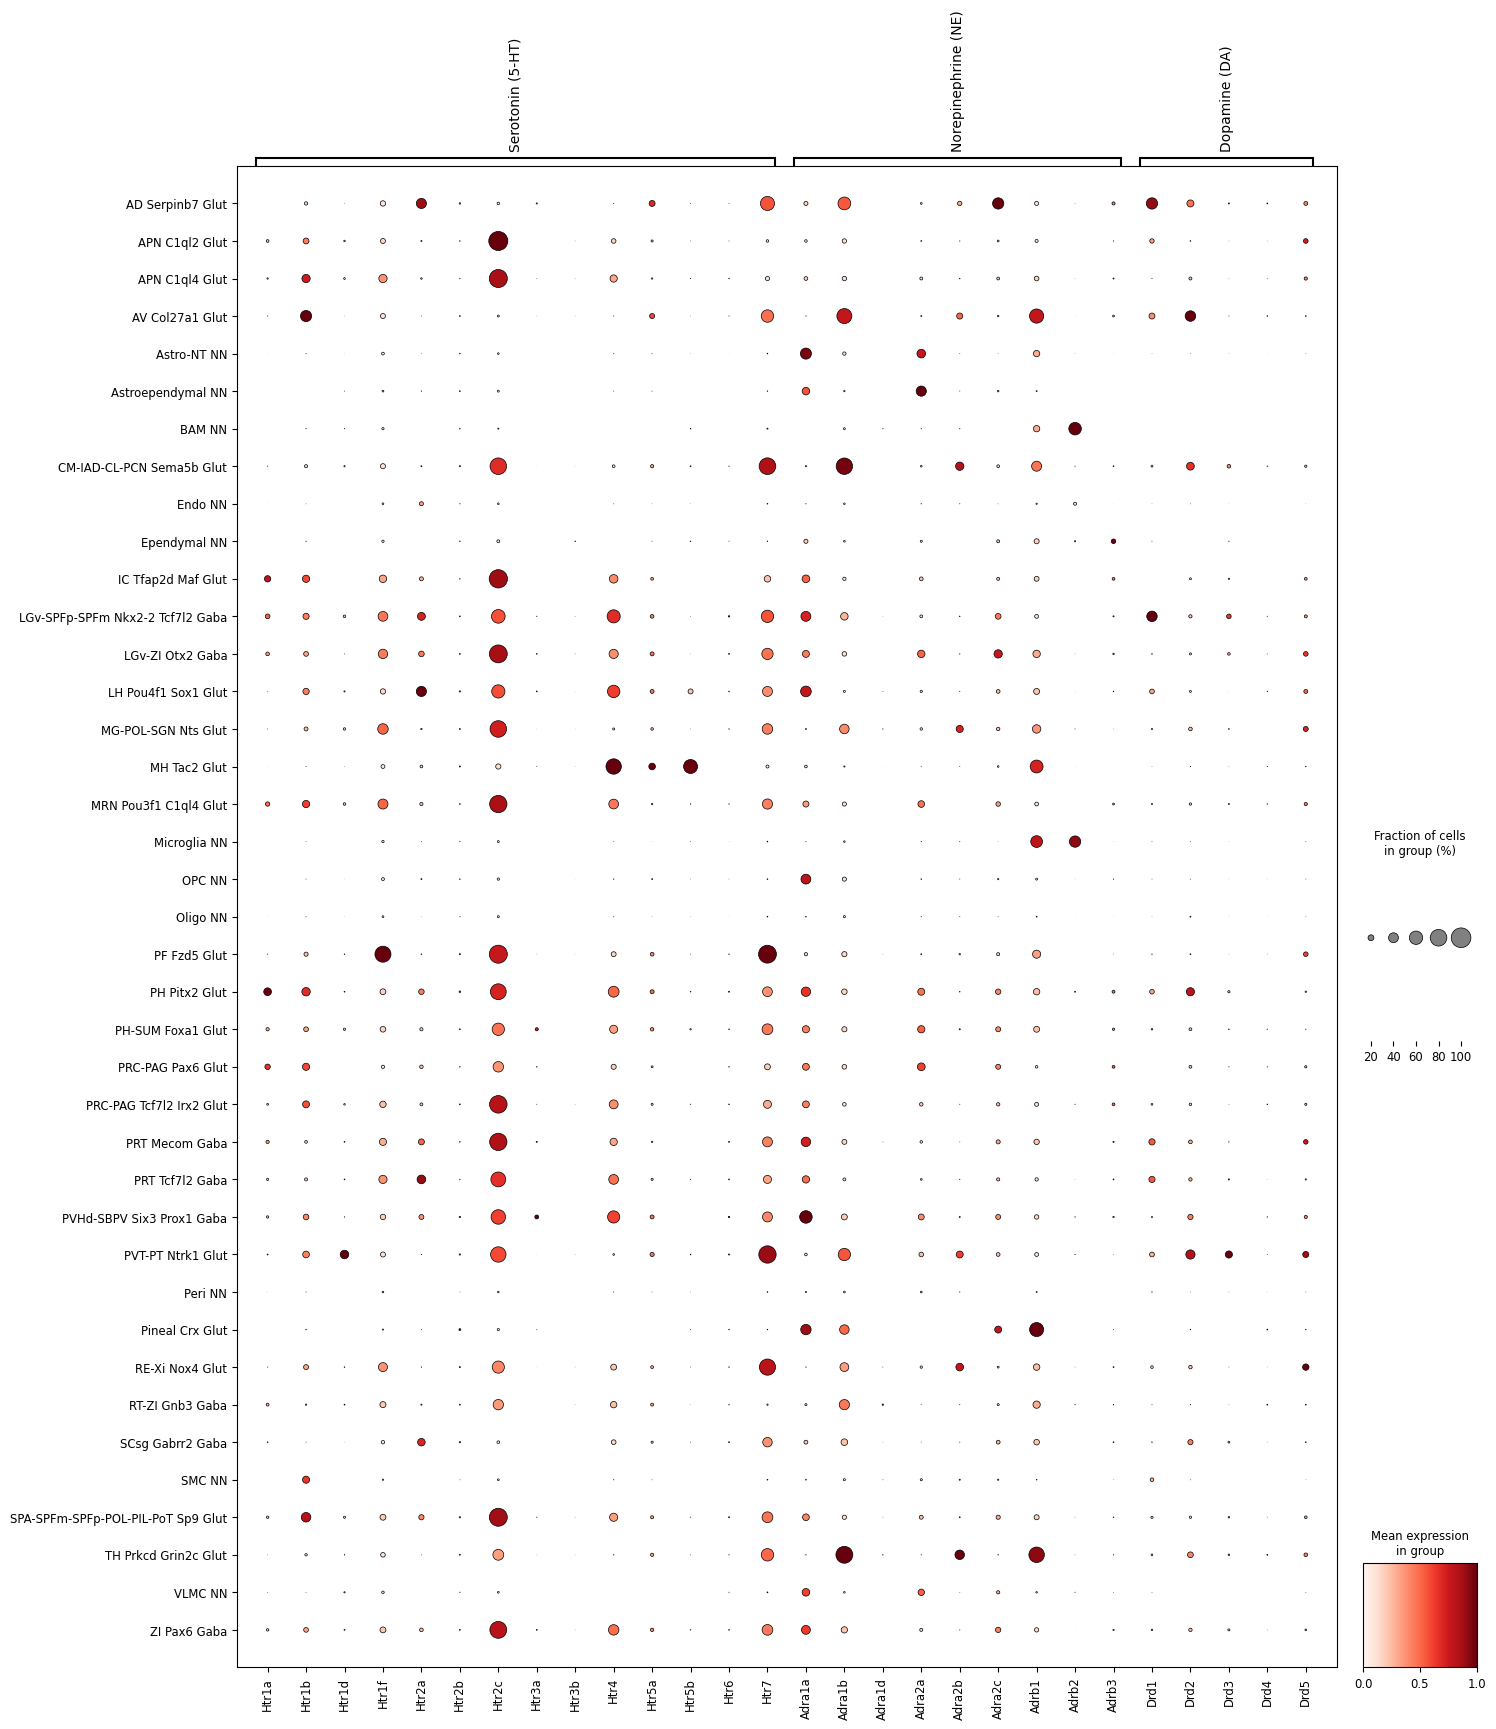

Saved: dotplot_TH_receptors_by_subclass.png


In [12]:
receptor_groups = {}
sero_available = [g for g in serotonin_receptors if g in receptor_genes]
ne_available = [g for g in norepinephrine_receptors if g in receptor_genes]
da_available = [g for g in dopamine_receptors if g in receptor_genes]
if sero_available: receptor_groups['Serotonin (5-HT)'] = sero_available
if ne_available: receptor_groups['Norepinephrine (NE)'] = ne_available
if da_available: receptor_groups['Dopamine (DA)'] = da_available

dp = sc.pl.dotplot(
    adata_th,
    var_names=receptor_groups,
    groupby='subclass_short',
    standard_scale='var',
    cmap='Reds',
    figsize=(16, max(6, n_subclasses * 0.5)),
    show=False,
    return_fig=True
)
dp.style(dot_edge_color='black', dot_edge_lw=0.5)
dp.savefig('dotplot_TH_receptors_by_subclass.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: dotplot_TH_receptors_by_subclass.png")

## 8. Finer View: Grouped by Supertype

Supertypes with >= 50 cells: 119


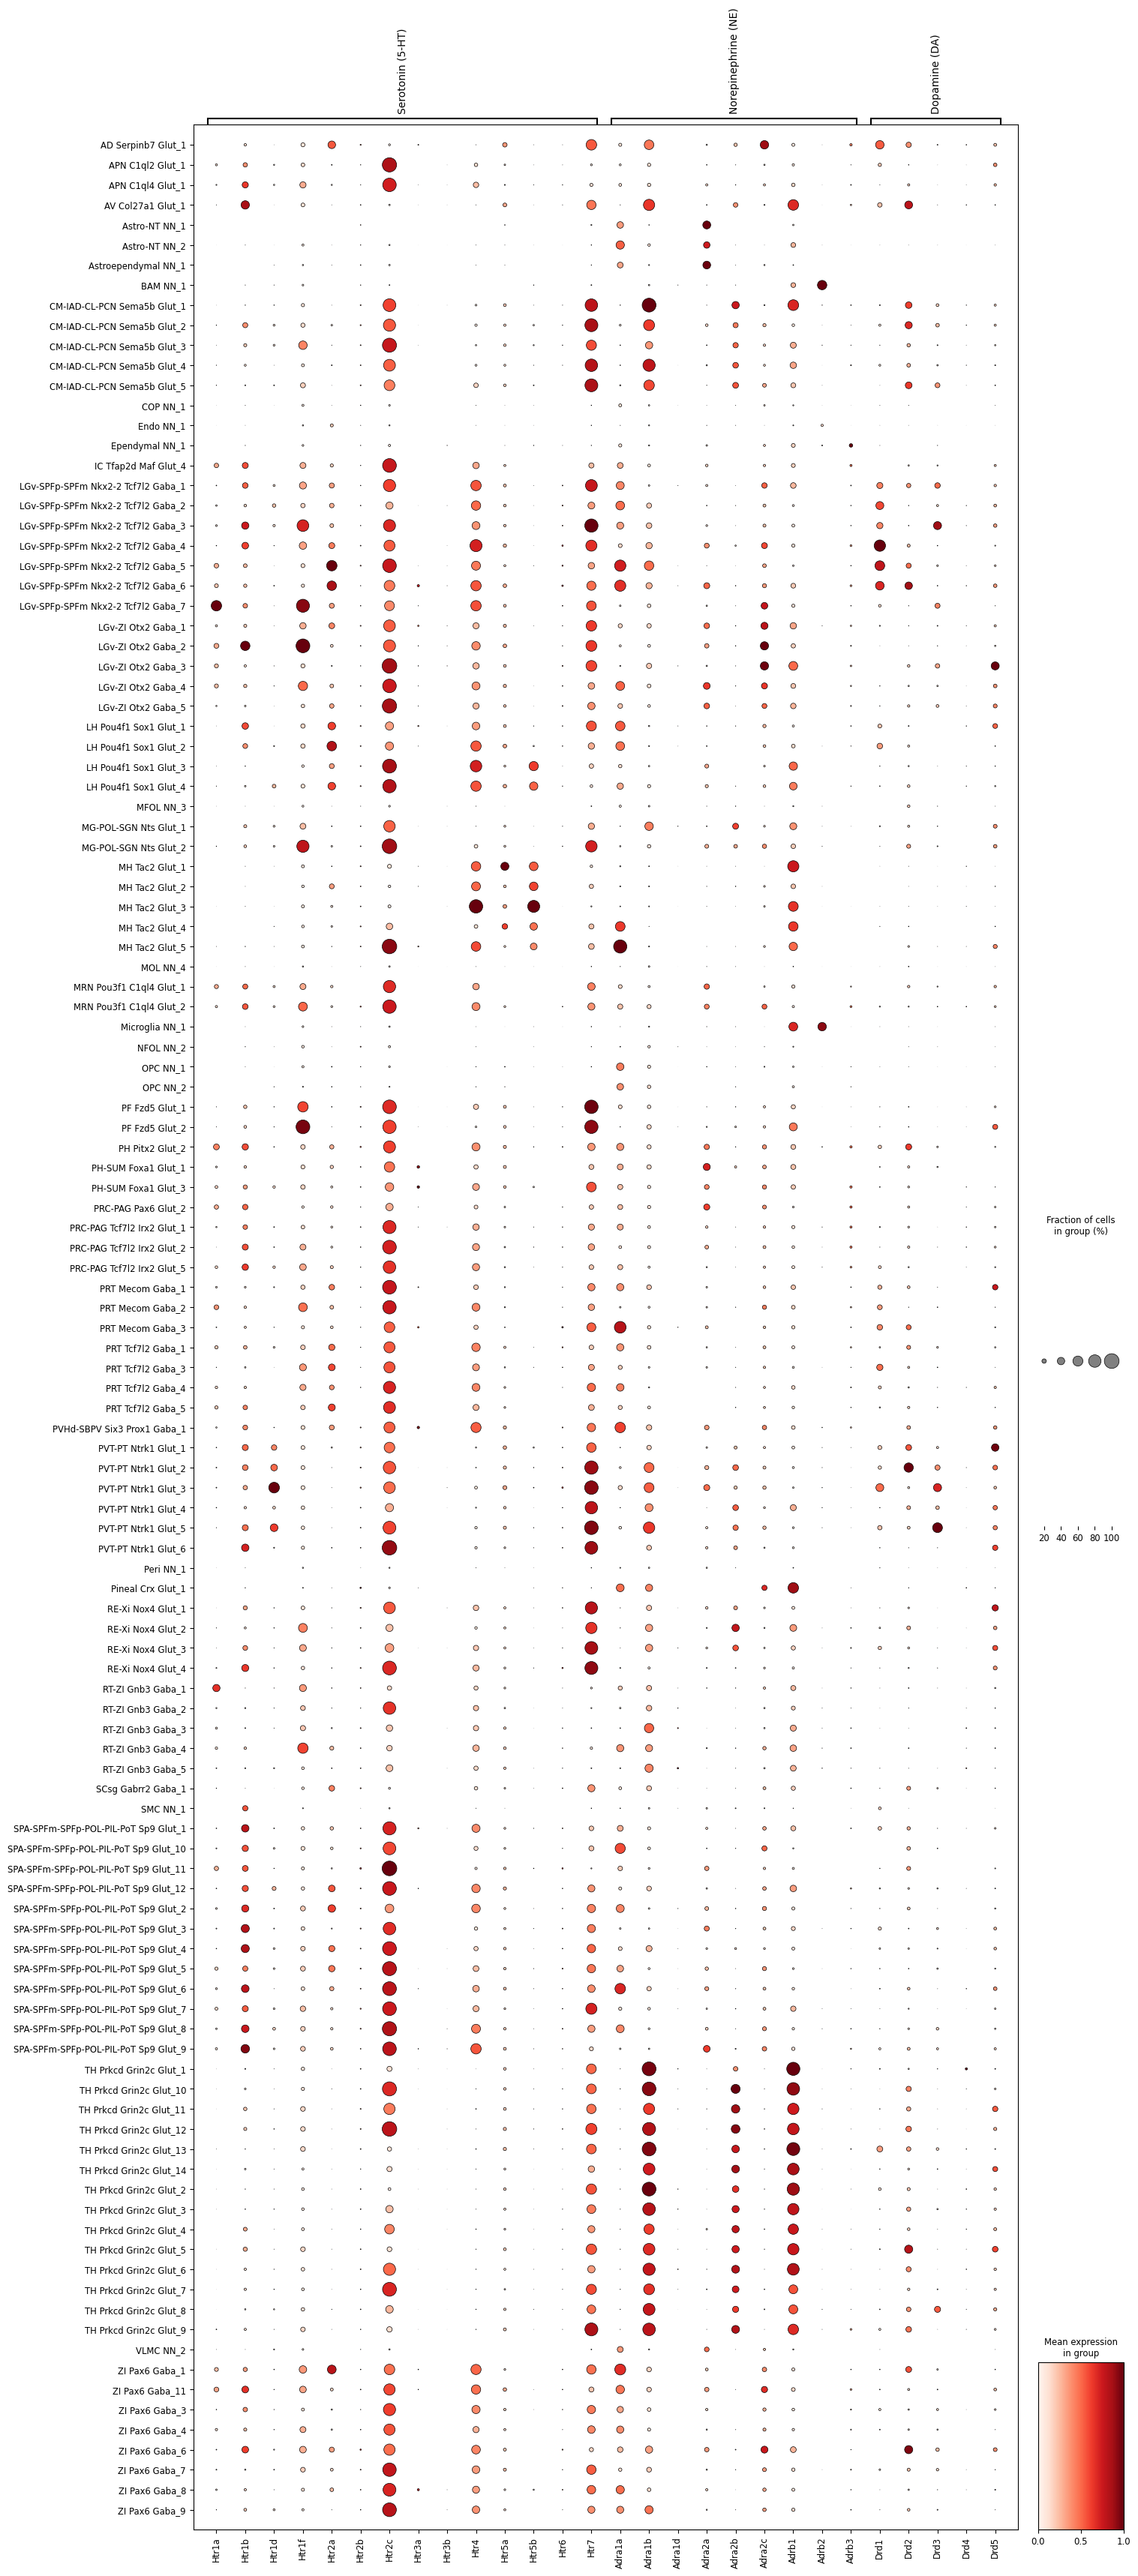

Saved: dotplot_TH_receptors_by_supertype.png


In [13]:
min_cells = 50
supertype_counts = adata_th.obs.groupby('supertype', observed=True).size()
valid_supertypes = supertype_counts[supertype_counts >= min_cells].index.tolist()

adata_st = adata_th[adata_th.obs['supertype'].isin(valid_supertypes)].copy()
adata_st.obs['supertype_short'] = pd.Categorical(adata_st.obs['supertype_short'])

n_st = len(valid_supertypes)
print(f"Supertypes with >= {min_cells} cells: {n_st}")

dp2 = sc.pl.dotplot(
    adata_st,
    var_names=receptor_groups,
    groupby='supertype_short',
    standard_scale='var',
    cmap='Reds',
    figsize=(16, max(8, n_st * 0.35)),
    show=False,
    return_fig=True
)
dp2.style(dot_edge_color='black', dot_edge_lw=0.5)
dp2.savefig('dotplot_TH_receptors_by_supertype.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: dotplot_TH_receptors_by_supertype.png")

## 9. Summary Statistics

In [14]:
expr_df = pd.DataFrame(
    adata_th.X,
    index=adata_th.obs.index,
    columns=adata_th.var.index
)
expr_df['subclass'] = adata_th.obs['subclass_short'].values

mean_expr = expr_df.groupby('subclass', observed=True)[receptor_genes].mean()
frac_expr = expr_df.groupby('subclass', observed=True)[receptor_genes].apply(
    lambda x: (x > 0).mean()
)

print("=" * 80)
print("Mean Expression (log2) by TH Subclass")
print("=" * 80)
display(mean_expr.round(2))

print("\n" + "=" * 80)
print("Fraction of Expressing Cells by TH Subclass")
print("=" * 80)
display(frac_expr.round(3))

Mean Expression (log2) by TH Subclass


,Htr1a,Htr1b,Htr1d,Htr1f,Htr2a,Htr2b,Htr2c,Htr3a,Htr3b,Htr4,...,Adra2b,Adra2c,Adrb1,Adrb2,Adrb3,Drd1,Drd2,Drd3,Drd4,Drd5
subclass,,,,,,,,,,,,,,,,,,,,,
AD Serpinb7 Glut,0.00,0.45,0.01,0.81,2.36,0.13,0.34,0.10,0.00,0.02,...,0.65,2.43,0.55,0.01,0.41,2.52,1.22,0.11,0.08,0.56
APN C1ql2 Glut,0.50,1.32,0.22,1.09,0.15,0.07,9.13,0.00,0.01,0.99,...,0.04,0.28,0.56,0.00,0.04,0.94,0.09,0.01,0.01,0.98
APN C1ql4 Glut,0.19,2.19,0.25,2.25,0.23,0.05,7.90,0.01,0.01,1.84,...,0.07,0.49,0.98,0.01,0.14,0.03,0.53,0.00,0.01,0.61
AV Col27a1 Glut,0.03,2.95,0.00,0.84,0.01,0.08,0.26,0.00,0.00,0.02,...,1.10,0.16,4.04,0.00,0.22,1.07,2.55,0.02,0.06,0.08
Astro-NT NN,0.00,0.03,0.00,0.52,0.01,0.07,0.27,0.00,0.00,0.02,...,0.02,0.01,1.60,0.01,0.00,0.01,0.01,0.01,0.00,0.01
Astroependymal NN,0.00,0.00,0.02,0.30,0.04,0.13,0.35,0.00,0.00,0.02,...,0.02,0.25,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00
BAM NN,0.00,0.04,0.04,0.38,0.00,0.08,0.16,0.00,0.00,0.00,...,0.03,0.00,1.64,4.17,0.00,0.00,0.00,0.00,0.00,0.00
CM-IAD-CL-PCN Sema5b Glut,0.03,0.48,0.14,0.90,0.11,0.12,6.25,0.00,0.00,0.42,...,1.78,0.39,2.46,0.02,0.08,0.24,1.69,0.59,0.04,0.33
Endo NN,0.00,0.01,0.00,0.28,0.88,0.04,0.27,0.00,0.00,0.02,...,0.03,0.01,0.19,0.60,0.00,0.01,0.01,0.00,0.00,0.00



Fraction of Expressing Cells by TH Subclass


,Htr1a,Htr1b,Htr1d,Htr1f,Htr2a,Htr2b,Htr2c,Htr3a,Htr3b,Htr4,...,Adra2b,Adra2c,Adrb1,Adrb2,Adrb3,Drd1,Drd2,Drd3,Drd4,Drd5
subclass,,,,,,,,,,,,,,,,,,,,,
AD Serpinb7 Glut,0.000,0.094,0.001,0.177,0.415,0.031,0.064,0.024,0.000,0.004,...,0.137,0.478,0.122,0.001,0.087,0.479,0.254,0.022,0.015,0.115
APN C1ql2 Glut,0.072,0.198,0.034,0.160,0.022,0.010,0.961,0.000,0.001,0.145,...,0.006,0.042,0.085,0.000,0.007,0.135,0.013,0.001,0.001,0.146
APN C1ql4 Glut,0.028,0.315,0.038,0.316,0.035,0.007,0.893,0.002,0.001,0.266,...,0.010,0.077,0.148,0.001,0.022,0.005,0.081,0.001,0.002,0.091
AV Col27a1 Glut,0.005,0.473,0.001,0.164,0.003,0.017,0.047,0.001,0.001,0.004,...,0.209,0.032,0.648,0.000,0.043,0.204,0.435,0.003,0.012,0.015
Astro-NT NN,0.000,0.004,0.000,0.074,0.001,0.011,0.038,0.000,0.000,0.003,...,0.002,0.002,0.222,0.001,0.000,0.001,0.002,0.001,0.000,0.001
Astroependymal NN,0.000,0.000,0.003,0.040,0.006,0.016,0.047,0.000,0.000,0.003,...,0.003,0.034,0.019,0.000,0.000,0.000,0.000,0.000,0.000,0.000
BAM NN,0.000,0.006,0.006,0.056,0.000,0.011,0.022,0.000,0.000,0.000,...,0.006,0.000,0.222,0.550,0.000,0.000,0.000,0.000,0.000,0.000
CM-IAD-CL-PCN Sema5b Glut,0.005,0.086,0.026,0.165,0.020,0.024,0.795,0.000,0.000,0.072,...,0.318,0.074,0.407,0.004,0.016,0.046,0.291,0.104,0.008,0.058
Endo NN,0.000,0.002,0.000,0.039,0.122,0.006,0.036,0.000,0.000,0.003,...,0.004,0.002,0.026,0.084,0.000,0.001,0.002,0.000,0.000,0.001
